In [3]:
import requests
from bs4 import BeautifulSoup
import re 
import pandas as pd 
from collections import Counter, defaultdict
import spacy
import time 
import sqlite3
import string 
import nltk 
from nltk.collocations import *
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np 
import pickle
import matplotlib.pyplot as plt
import seaborn as sb
from gensim.models import Word2Vec
from gensim.models.word2vec import FAST_VERSION
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import multiprocessing
import random
from sklearn.decomposition import TruncatedSVD 
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors
import seaborn as sb
sb.set_context('notebook')
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.colors as mcolors
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import NMF


https://www.jennadallen.com/post/text-analytics-every-line-from-the-office/#:~:text=Text%20Analytics-,Word%20Frequencies,-I%E2%80%99ll%20start%20by

# Midterm Project

The midterm project is designed to let you apply what you have learned so far, and demonstrate that you have mastered it. The submission will be graded on the correctness of the execution of your analysis (50%), the ambitiousness of the problems chosen (30%), and the creativity of your questions and solutions (20%).

Please note that the project is ***individual***, and the solutions will be checked for substantial overlap. However, you should feel free to discuss problems and ideas with your class mates, just do not share code.

Your submission should include all input data and outputs and be **self-contained**, so it can be executed by us if necessary.


## Submission
The project is due on ***March 28 2022, 23:59 CET***. The time stamp of the email or upload determines the submission time. *Late submissions will NOT be considered, and graded as 0.*

Submitting the midterm means you will be counted as attending student, meaning the final project is a group project. You can **not** switch status after the midterm deadline.

To submit, please:

1. rename this file with your student ID
2. copy this file and all additional data into a folder with your student ID
3. zip the entire folder
4. send a copy of the zip file to Amanda Cercas Curry <amanda.cercas@unibocconi.it>

For large files, you can use **wetransfer**. Please do not use Dropbox links, since they are not time-stamped!

## 1. Data and Preprocessing (5 pts)

Pick a data set with **at least 5,000** documents that you have found yourself.
Briefly (max. 100 words!) describe the content and type of the data set (book, reviews, Twitter, ...). 

Preprocess the data and explain (max. 200 words) which preprocessing steps you chose and why, and give statistics of the number of documents, types, and tokens, before and after preprocessing.

### 1.1.1 Explain Briefly the project

For the project we are going to use in a conjoint way two dataset:

The **"The Office"** we can find every line from the show. Available in googlesheet: https://docs.google.com/spreadsheets/d/18wS5AAwOh8QO95RwHLS95POmSNKA2jjzdt0phrxeAE0/edit#gid=747974534 [Found on the web] 
Will be analyzed the lines from the 'The Office' TV-Series. In the dataset are available information about the season, the episode, the scene in which a certain line has been pronounced and the character who is telling it. 

The **reviews'** dataset. Obtained trough Beautiful soup [*External library]. It is a series of reviews posted on IMDB about 'The Office'. The data have been defined respecting the structure of the main dataset. Are represented the season and the episode to which the review is referred, the review score, who posted the review, when the review was posted, the review_text, and how many found the review useful. 

Further information about the applied preprocessing steps are in the next sections. 

<div class="alert alert-block alert-warning">
    WARNING - This analysis could contain spoilers !

### 1.2 Pre processing steps: making the data readable [*External library used]

**Review_dataset**: To compile the final csv file some RegEx have been used, to define information about:
- Season
- Episode 
- Useful 

Here a toy example will be provided to illustrate how the pre-processing step has been realized in the scraper. For further information about how the scraper has been realized,please, consult the 'Review_scraper.ipynb'.

In [2]:
reviews_pre = pd.read_csv('reviews.csv')
reviews = reviews_pre.drop(columns = ['Unnamed: 0']).sort_values(by = ['season','episode']).reset_index(drop=True)
reviews.head()

,season,episode,Rating,Name,Date,Text,Useful
0,1,1,7.0,ComedyFan2010,27 December 2018,The pilot episode of the great show The Office...,4/7
1,1,1,5.0,studioAT,17 October 2021,The American version of the UK show kicks off ...,2/6
2,1,1,8.0,Edvis-1997,24 October 2021,Wathcing it for the first time after 16 years ...,1/3
3,1,1,9.0,MaxBorg89,16 January 2009,When it was first announced that NBC was going...,37/42
4,1,1,9.0,MrFilmAndTelevisionShow,17 February 2021,I've only watched the first episode of each se...,3/6


In [3]:
#Extract Season and Episode 
page = requests.get('https://www.imdb.com/title/tt0386676/episodes?season=1') 
soup = BeautifulSoup(page.content, "html.parser") 
reference = soup.find('div', class_='list_item odd').find('a').find('div').find('div').text

preprocess_S_E = [reference]
season = [re.findall('[0-9]+',reference)[0]]
episode = [int(re.findall('[0-9]+',reference)[1])]

pd.DataFrame(list(zip(preprocess_S_E,season,episode)),columns = ['preprocess_S_E','season','episode'])

,preprocess_S_E,season,episode
0,"S1, Ep1",1,1


In [4]:
#Evaluate how many reviews are useful 
URL_review_S1_E1 = 'https://www.imdb.com/title/tt0664521/reviews'
page = requests.get(URL_review_S1_E1) 
soup = BeautifulSoup(page.content, "html.parser") 

preprocess_helpful = str(soup.find('div', class_ = 'lister-item-content').find('div', class_ = 'content').find('div', class_ = 'actions text-muted').text)
helpful = str(re.findall('[0-9]+',preprocess_helpful)[0]+'/'+re.findall('[0-9]+',preprocess_helpful)[1])

print('BEFORE RegEx', preprocess_helpful, '\nAFTER RegEx\n', helpful)

BEFORE RegEx 
                    4 out of 7 found this helpful.
                        
                            Was this review helpful?  Sign in to vote.
                        

Permalink
 
AFTER RegEx
 4/7


---
**Scripts dataset** : 
This data, like the majority of data isn’t perfect, but it’s in pretty good shape. There are some clean up steps we need to do:

- 1. Filter out deleted scenes;
- 2. Remove text in brackets ([]) and put in a new column called actions;
- 3. There are 4000+ instances of ??? found in the data mainly in the last two seasons. The ??? replaces … - ’ and “. For now I’m just going to replace all instances with ’ since - that seems to be the majority of the cases
- 4. Change speaker to lower case since there is some inconsistent capitalization
- 5. Some entries for speakers have actions ([]), which I’ll remove
- 6. Fix misspellings in the speaker field (e.g. Micheal instead of Michael)
- 7. Remove wrong entries in speaker: By a fast analysis is possible to notice that there are 3 WRONG OCCURENCES, in the set of speakers, these are listed in wrong_entries and will be dropped through a left join.
- 8. Remove lines with no text but just actions 

In [5]:
scripts_pre = pd.read_csv('the-office-lines-scripts.csv')

In [6]:
# 1. Filter out deleted sentences 
scripts = scripts_pre[scripts_pre['deleted']==0].reset_index(drop='True')

# 2. Remove text in brackets ([]) and put in a new column called actions
scripts['Actions'] = scripts.apply(lambda row: re.findall("\[.*?\]",row.line_text), axis=1)
scripts['line_text'] = scripts['line_text'].replace(to_replace = "\[.*?\]", value ="", regex = True)
act_list = []
line = ''
for act_line in scripts['Actions'].to_list():
    if act_line == []:
        act_list.append(['NA'])
    else:
        for act in act_line:
            line += act[1:-1].lower() +', '
        act_list.append([line.rstrip(', ')])
        line = ''
scripts['Actions_clean'] = pd.Series(act_list)
    
# 3. There are 4000+ instances of ???. The ??? replaces ’ 
scripts = scripts.replace(to_replace ="���", value = "'", regex = True)
scripts = scripts.replace(to_replace ="��", value = "'", regex = True)

# 4. Change speaker to lower case since there is some inconsistent capitalization
scripts['speaker'] = scripts['speaker'].apply(lambda x:x.lower())

# 5. Some entries for speakers have actions ([]), which I’ll remove
scripts[['speaker']] = scripts[['speaker']].replace(to_replace = "\[.*?\]", value ="", regex = True)

# 6. Fix misspellings in the speaker field (e.g. Micheal instead of Michael)
scripts[['line_text']] = scripts[['line_text']].replace(to_replace ="micheal|michel|michae$", value = "michael", regex = True)

# 7. Remove wrong entries in speaker 
wrong_entries = scripts[(scripts['speaker'] == '\nandy: fail') | (scripts['speaker'] == 'group: dunder mifflin!\nandy: andy bernard presents: summer softball epic fails!  fail.  fail')| (scripts['speaker']=="\nvideo andy: hey, i'm pete, puberty is such a drag, man. and i'm clark! i like to eat toilet paper.  we fail! [video shows memorial of jerry")]
mask1 = ~scripts.index.isin(wrong_entries.index)
scripts = scripts.loc[mask1].reset_index(drop=True)

#8. Remove lines with no text 
null_entries = scripts[scripts['line_text']=='']
mask2 = ~scripts.index.isin(null_entries.index)
scripts = scripts.loc[mask2].reset_index(drop=True)

# Final 
scripts = scripts.drop(['deleted','Actions'],axis = 1)
scripts = scripts.rename(columns={'Actions_clean':'Actions'})

In [7]:
scripts.head(10)

,id,season,episode,scene,line_text,speaker,Actions
0,1,1,1,1,All right Jim. Your quarterlies look very good...,michael,[NA]
1,2,1,1,1,"Oh, I told you. I couldn't close it. So...",jim,[NA]
2,3,1,1,1,So you've come to the master for guidance? Is ...,michael,[NA]
3,4,1,1,1,"Actually, you called me in here, but yeah.",jim,[NA]
4,5,1,1,1,"All right. Well, let me show you how it's done.",michael,[NA]
5,6,1,1,2,"Yes, I'd like to speak to your office manager...",michael,"[on the phone, quick cut scene, hangs up, clea..."
6,7,1,1,3,"I've, uh, I've been at Dunder Mifflin for 12 y...",michael,[NA]
7,8,1,1,3,Well. I don't know.,pam,[NA]
8,9,1,1,3,"If you think she's cute now, you should have s...",michael,[growls]
9,10,1,1,3,What?,pam,[NA]


### 1.3 Preprocessing steps: reducing the noise in data 

Before to proceed inanalysis will be necessary to perform some further preprocessing steps and in particular we will have to:
- remove punctuation
- lemmatize the words
- remove stopwords 
- remove additional stopwords: these are specific word with actually no meaning that would make our analysis more noisy 
- substitute numbers 
- substitute collocations 

this steps will be important to reduce the noise in the text and extract meaningful information. To make our job easier i have defined some functions to prooceed in the preprocessing steps. 



#### 1.3.1 Functions used for preprocessing 

In [8]:
nlp = spacy.load('en_core_web_sm')

In [104]:
def clean_list_of_list(corpus_list,additional_stop=0): 
    
    ''' corpus_list: a list of lists in which text is contained 
    the function will: 
    -lemmatize all the words, 
    -remove punctuation, 
    -remove stopwords, the additional parameter is to include some of the most frequent words in the script and to make our analysis more meaningful 
    -remove verbs, is an additional parameter that is useful in our tfidf evaluation
    -generalize numerical character.
    It will return a list of lists where each of the lists represent a sentence and each word represents an element of it'''
    
    SYMBOLS = " ".join(string.punctuation).split(" ") + ["-----", "---", "...",""]
    if additional_stop == 0:
        STOPWORDS_ = set(stopwords.words('english'))
    else:
        STOPWORDS_ = set(stopwords.words('english')).union(["yeah", "hey", "uh", "um", "huh", "hmm", "ah", "umm", "uhh", "gonna", "na", "ha", "gotta"])

    NUMBERS = re.compile('[0-9]')
    nlp = spacy.load('en_core_web_sm')
    
    #lemmatize
    sentences = []
    for s in corpus_list:
        sentences.append([tok.lemma_.lower().strip() if tok.lemma_ != "-PRON-" else tok.lower_ for tok in nlp(s)])

    clean_sent = sentences
        
    #remove punctuation 
    clean_sent = [[tok for tok in sent if tok not in SYMBOLS] for sent in clean_sent]

    #remove stopwords and words with less than 2 letters 
    clean_sent = [[tok for tok in sent if tok not in STOPWORDS_ and len(tok)>2] for sent in clean_sent]

    #remove numbers 
    clean_sent = [[re.sub(NUMBERS,'0', tok) for tok in sent] for sent in clean_sent]
    
    return clean_sent

def clean_word_list(corpus_list, additional_stop=0):
    ''' returns a list in which all the words are contained'''
    nlp = spacy.load('en_core_web_sm')
    SYMBOLS = " ".join(string.punctuation).split(" ") + ["-----", "---", "...",""]
    if additional_stop == 0:
        STOPWORDS_ = set(stopwords.words('english'))
    else: 
        STOPWORDS_ = set(stopwords.words('english')).union(["yeah", "hey", "uh", "um", "huh", "hmm", "ah", "umm", "uhh", "gonna", "na", "ha", "gotta"])
    NUMBERS = re.compile('[0-9]')
    
    
    #lemmatize 
    lemmas = []
    for sentence in corpus_list: 
        for tok in nlp(sentence):
            lemmas.append(tok.lemma_.lower().strip() if tok.lemma_ != "-PRON-" else tok.lower_)
            
    tokens = lemmas

    #remove punctuation 
    tokens = [tok for tok in tokens if tok not in SYMBOLS]

    #remove stopwords
    tokens = [tok for tok in tokens if tok not in STOPWORDS_ and len(tok)>2]
    
    #remove numbers 
    tokens = [re.sub(NUMBERS,'0', tok) for tok in tokens]
    
    return tokens 

def collocation_finder(word_list,tresh = 1):
    '''corpus: the text we mean to analize, it should be formatted as a list of lists
    treshold: the minimum mi_like score to consider a pair of words as a colocation
    returns (scores, dictionary of collocations )'''
    bi_finder = nltk.collocations.BigramCollocationFinder.from_words(word_list)
    bgm = nltk.collocations.BigramAssocMeasures()
    bi_collocations_scr = {'_'.join(bigram): pmi for bigram, pmi in bi_finder.score_ngrams(bgm.mi_like) if pmi > tresh}
    bi_collocations_scr_dict = {' '.join(bigram): '_'.join(bigram) for bigram, pmi in bi_finder.score_ngrams(bgm.mi_like) if pmi > tresh}
    
    return bi_collocations_scr, bi_collocations_scr_dict

def collocation_substituter(document_list,collocation_dictionary, tresh=1): 
    '''maybe corpus should be a list of lists '''
    sentences = document_list 
    
    res = []
    for sentence in sentences:
        sent = ''
        for word in sentence:
            sent += word + " "
            for key,value in collocation_dictionary[1].items():
                if key in sent:
                    sent = sent.replace(key,value)

        res.append(sent.rstrip(' '))

    return res

#### 1.3.2 Getting the clean CSV  

In [ ]:
#DO NOT RUN ! 
#don't run, given high computational time we will save it using pickles 
basic_scr = scripts.line_text.to_list()
basic_rew = reviews.Text.to_list()
scr_d_list_no_additional_stop = clean_list_of_list(basic_scr) 
scr_w_list_no_additional_stop = clean_word_list(basic_scr)
scr_d_list = clean_list_of_list(basic_scr, additional_stop = 1) 
scr_w_list = clean_word_list(basic_scr, additional_stop = 1)  
rew_d_list = clean_list_of_list(basic_rew) 
rew_w_list = clean_word_list(basic_rew)

with open("scr_w_list.pkl", "wb") as fp:   
    pickle.dump(scr_w_list, fp)
with open("scr_d_list.pkl", "wb") as fp:
    pickle.dump(scr_d_list, fp)
with open("scr_w_list_no_additional_stop.pkl", "wb") as fp:   
    pickle.dump(scr_w_list_no_additional_stop, fp)
with open("scr_d_list_no_additional_stop.pkl", "wb") as fp:
    pickle.dump(scr_d_list_no_additional_stop, fp)
with open("rew_d_list.pkl", "wb") as fp:   
    pickle.dump(rew_d_list, fp)
with open("rew_w_list.pkl", "wb") as fp:   
    pickle.dump(rew_w_list, fp)

In [5]:
# TO RUN 
with open('scr_w_list.pkl', 'rb') as f:
    scr_w_list = pickle.load(f)
with open('scr_d_list.pkl', 'rb') as f:
    scr_d_list = pickle.load(f)
with open("scr_w_list_no_additional_stop.pkl", "rb") as f:   
    scr_w_list_no_additional_stop = pickle.load(f)
with open("scr_d_list_no_additional_stop.pkl", "rb") as f:
    scr_d_list_no_additional_stop = pickle.load(f)
with open('rew_w_list.pkl', 'rb') as f:
    rew_w_list = pickle.load(f)
with open('rew_d_list.pkl', 'rb') as f:
    rew_d_list = pickle.load(f)

#### 1.3.3 The impact of the additional stopwords in the scripts analysis  

57580

In [11]:
words_eval = [len(scr_w_list_no_additional_stop), len(scr_w_list)]
df_stopwords = pd.DataFrame({'#words':words_eval}, index = ['NO ADD STOPWORDS','ADD STOPWORDS'])
df_stopwords

,#words
NO ADD STOPWORDS,274663
ADD STOPWORDS,268462


In [6]:
scr_w_list

['right',
 'jim',
 'quarterly',
 'look',
 'good',
 'thing',
 'library',
 'tell',
 'could',
 'close',
 'come',
 'master',
 'guidance',
 'say',
 'grasshopper',
 'actually',
 'call',
 'right',
 'well',
 'let',
 'show',
 'yes',
 'like',
 'speak',
 'office',
 'manager',
 'please',
 'yes',
 'hello',
 'michael',
 'scott',
 'regional',
 'manager',
 'dunder',
 'mifflin',
 'paper',
 'products',
 'want',
 'talk',
 'manager',
 'manger',
 'right',
 'deal',
 'thank',
 'much',
 'sir',
 'gentleman',
 'scholar',
 'sorry',
 'sorry',
 'mistake',
 'woman',
 'talk',
 'low',
 'voice',
 'probably',
 'smoker',
 'way',
 'dunder',
 'mifflin',
 'year',
 'last',
 'four',
 'regional',
 'manager',
 'want',
 'come',
 'see',
 'entire',
 'floor',
 'kingdom',
 'far',
 'eye',
 'see',
 'receptionist',
 'pam',
 'pam',
 'pam',
 'pam',
 'pam',
 'beesly',
 'pam',
 'forever',
 'right',
 'pam',
 'well',
 'know',
 'think',
 'cute',
 'see',
 'couple',
 'year',
 'ago',
 'message',
 'fax',
 'pam',
 'corporate',
 'many',
 'time',
 

#### 1.3.4 Substitute collocations 

In [ ]:
#scripts 
scr_collocation_d = collocation_finder(scr_w_list)
clean_script = collocation_substituter(scr_d_list, scr_collocation_d)
scripts['clean_script'] = pd.Series(clean_script)
clean_scr_tokens = [[token.text for token in nlp(sentence)] for sentence in scripts['clean_script']]
scripts['clean_script_tokens'] = pd.Series(clean_scr_tokens)

#reviews 
rew_collocation_d = collocation_finder(rew_w_list)
clean_rew = collocation_substituter(rew_d_list, rew_collocation_d)
reviews['clean_text'] = pd.Series(clean_rew)
clean_rew_tokens = [[token.text for token in nlp(sentence)] for sentence in reviews['clean_text']]
reviews['clean_text_tokens'] = pd.Series(clean_rew_tokens)

In [ ]:
scr_collocation_d[0] #collocation scores in the script 

In [ ]:
rew_collocation_d = collocation_finder(rew_w_list)
clean_rew = collocation_substituter(rew_d_list, rew_collocation_d)
reviews['clean_text'] = pd.Series(clean_rew)
clean_rew_tokens = [[token.text for token in nlp(sentence)] for sentence in reviews['clean_text']]
reviews['clean_text_tokens'] = pd.Series(clean_rew_tokens)


In [ ]:
rew_collocation_d[0] #collocation scores in the reviews 

In [ ]:
#DON'T RUN - Computationally expensive so we save the df 
reviews.to_csv('final_reviews.csv')
scripts.to_csv('final_scripts.csv')

In [13]:
scripts.head()

,id,season,episode,scene,line_text,speaker,Actions
0,1,1,1,1,All right Jim. Your quarterlies look very good...,michael,[NA]
1,2,1,1,1,"Oh, I told you. I couldn't close it. So...",jim,[NA]
2,3,1,1,1,So you've come to the master for guidance? Is ...,michael,[NA]
3,4,1,1,1,"Actually, you called me in here, but yeah.",jim,[NA]
4,5,1,1,1,"All right. Well, let me show you how it's done.",michael,[NA]


It is possible to notice that there are many interesting collocations with an high score within the **script** , but the highest is associated to the bigram 'dunder mifflin' which is the name of the company where the tv-series takes place. Other interesting ones are referred to specific roles in the office ('regional manager', 'planning committee') and some character in the series ('david wallace', 'michael scott'). We will substitute the bigrams that have an mi_like score (Scores ngrams using a variant of mutual information) over 1. 

About the **reviews**, we can see that also here dundler mifflin is the dominant collocation, followed by 'steve carell' which is the actor representing the main character of the series. In fact the reviews don't limit themselves to the show itself but also go further in evaluating the actors. Is also interesting the jim_pam collocation. The two character represent the main love story of the show and we will try to further analyze this relationship. 

# --> Upload the DF 

In [3]:
scripts= pd.read_csv('final_scripts.csv',converters={'Actions':literal_eval,'clean_script_tokens':literal_eval}).drop(columns=['Unnamed: 0'])
reviews = pd.read_csv('final_reviews.csv',converters={'clean_text_tokens':literal_eval}).drop(columns=['Unnamed: 0'])

In [4]:
scripts.head()

,id,season,episode,scene,line_text,speaker,Actions,clean_script,clean_script_tokens
0,1,1,1,1,All right Jim. Your quarterlies look very good...,michael,[NA],right jim quarterly look good thing library,"[right, jim, quarterly, look, good, thing, lib..."
1,2,1,1,1,"Oh, I told you. I couldn't close it. So...",jim,[NA],tell could close,"[tell, could, close]"
2,3,1,1,1,So you've come to the master for guidance? Is ...,michael,[NA],come master guidance say grasshopper,"[come, master, guidance, say, grasshopper]"
3,4,1,1,1,"Actually, you called me in here, but yeah.",jim,[NA],actually call,"[actually, call]"
4,5,1,1,1,"All right. Well, let me show you how it's done.",michael,[NA],right well let show,"[right, well, let, show]"


In [5]:
reviews.head()

,season,episode,Rating,Name,Date,Text,Useful,clean_text,clean_text_tokens
0,1,1,7.0,ComedyFan2010,27 December 2018,The pilot episode of the great show The Office...,4/7,pilot episode great show office good_episode g...,"[pilot, episode, great, show, office, good_epi..."
1,1,1,5.0,studioAT,17 October 2021,The American version of the UK show kicks off ...,2/6,american version show kick like pilot much sho...,"[american, version, show, kick, like, pilot, m..."
2,1,1,8.0,Edvis-1997,24 October 2021,Wathcing it for the first time after 16 years ...,1/3,wathce first time year release still make laug...,"[wathce, first, time, year, release, still, ma..."
3,1,1,9.0,MaxBorg89,16 January 2009,When it was first announced that NBC was going...,37/42,first announce nbc adapt bbc hit office americ...,"[first, announce, nbc, adapt, bbc, hit, office..."
4,1,1,9.0,MrFilmAndTelevisionShow,17 February 2021,I've only watched the first episode of each se...,3/6,watch first episode series far brit think pref...,"[watch, first, episode, series, far, brit, thi..."


### 1.4 Preprocessing statistics  
Right now I will extrapolate just statistics from the pre_dataset and from the reviews, some further preprocessing will be applied during the analysis based on the specific implementation. 

In [15]:
nlp = spacy.load('en_core_web_sm')

In [20]:
%timeit 
#documents statistics 

d_scripts = [len(scripts_pre['line_text']),len(scripts['clean_script'])]
d_reviews = [len(reviews['Text']), len(reviews['clean_text'])]

documents_df = pd.DataFrame({'Scripts':d_scripts, 'Reviews':d_reviews}, index = ['PRE','AFTER'])

#tokens statistics 
scripts_pre_tokens = [token.text for sentence in scripts_pre['line_text'].to_list() for token in nlp(sentence)] #OK 
scripts_tokens = [token.text for sentence in scripts[scripts['clean_script'].notna()]['clean_script'].to_list() for token in nlp(sentence)] 
speaker_pre_tokens = [token.text for sentence in scripts_pre['speaker'].to_list() for token in nlp(sentence)]   #OK
speaker_tokens = [token.text for sentence in scripts['speaker'].to_list() for token in nlp(sentence)]           #OK

num_actions = 0 
num_actions_token = 0 
for script in scripts['Actions'].to_list():
    for i in script:
        if i!='NA':
            num_actions += len(i.split(','))
            num_actions_token += len(i.split())
            
reviews_tokens_pre = [token.text for sentence in reviews['Text'].to_list() for token in nlp(sentence)]
reviews_tokens = [token.text for sentence in reviews['clean_text'].to_list() for token in nlp(sentence)]

t_scripts = [len(scripts_pre_tokens),len(scripts_tokens)]               
t_speaker = [len(speaker_pre_tokens),len(speaker_tokens)]               
t_set_speaker = [len(set(speaker_pre_tokens)),len(set(speaker_tokens))] 
actions = [0,num_actions] 
t_actions = [0, num_actions_token]
t_reviews = [len(reviews_tokens_pre),len(reviews_tokens)]                                                          

tokens_df = pd.DataFrame({'tokens reviews':t_reviews, 'tokens lines':t_scripts,'tokens speaker':t_speaker,'tokens actions':t_actions,'number speakers':t_set_speaker,'number actions':actions}, index = ['PRE','AFTER'])

#types statistics 

scr_types_pre = len(set(scripts_pre_tokens))
scr_types = len(set(scripts_tokens))
scr_t_types = [scr_types_pre, scr_types]  

rew_types_pre = len(set(reviews_tokens_pre))
rew_types = len(set(reviews_tokens))
rew_t_types =[rew_types_pre, rew_types]

types_df = pd.DataFrame({'script line': scr_t_types, 'reviews':rew_t_types}, index = ['PRE','AFTER'])

In [21]:
tokens_df    # tokens statistics 

,tokens reviews,tokens lines,tokens speaker,tokens actions,number speakers,number actions
PRE,143339,929022,62434,0,733,0
AFTER,61347,264095,59836,46454,640,12262


In [22]:
documents_df # documents statistics 

,Scripts,Reviews
PRE,59909,1354
AFTER,57580,1354


In [23]:
types_df     # types statistics 

,script line,reviews
PRE,26659,9491
AFTER,16416,6380


<div class="alert alert-block alert-success">
1.4 Interpretation

It is possible to notice that the noise in the data has been dramatically reduced through the performed preprocessing steps. Looking at the token_df table, we can see that the number of tokens in the reviews ('tokens reviews') was almost halved; meanwhile, for the lines ('tokens lines'), the impact of preprocessing has been even more robust. With 'tokens speaker', we refer to the number of tokens in the speaker column; as we can see, its number has been reduced, but the effect of preprocessing has not been that drastic. This happened because in that column were present just the names of the characters speaking in a specific line, so preprocessing has just fixed the miss-spellings. The number of tokens for the actions ('token action') increments by a lot, and this is because the actions were initially incorporated in the 'line_text' column , making their analysis harder. About the last two columns of the tokens_df we can find the number of unique speakers in the scripts and the number of actions that are performed. 

Preprocessing also brought us to remove some rows from the script dataframe; meanwhile, we kept all of them for the review one. 

For types, we can see that these have been reduced both in the script and in the reviews through preprocessing. 

Now our data are ready for analysis! 

## 2. Analysis (15 pts)

Describe what question you are investigating with the data (max. 100 words).

Use at least **five** of the following analysis methods to the data set (justify your choices and make them explicit):

- TFIDF analysis
- Word embeddings 
- Document embeddings
- Topic models
- Dimensionality reduction
- Clustering
- Language models

Justify your choice of the number of latent dimensions/topics/clusters!

Your analysis needs to be run on **at least 5,000** preprocessed documents!

If appropriate for your problem, feel free to explore other methods we discussed (NER, parsing, POS, etc.), or algorithms not covered in class (e.g., clustering algorithms, etc.). If they do require additional libraries, please mark this explicitly.
(up to 2 bonus points)

### 2.0 The problem to investigate
The project aims to analyze in detail the lines of the show text and try to understand the behavior of some of the main characters and the script as a whole. It will be not easy as I think that much of the comicality in the show is not due to the lines but to the ability of the actors to pronounce them properly. In particular, we will try to reveal character nuances by analyzing their lines using the tools studied in the NLP course. Further detail about how the analysis has been developed and its results will be found in each section.

Through the review dataset, we are going deeper in our analysis, trying to understand if there are specific patterns that excite the ultimate user of the series and understand better how they express their idea about the tv show. 

## 2.1 Data Exploration for Analysis preparation

#### 2.1.1 Scripts: Main character evaluation 

There are 733 characters, and for simplicity, in this section we will define which ones are the main characters in the series based on text data.

In [3]:
# tot_scenes 
scripts['season_ep_scene'] = scripts['season'].astype(str) + '_' + scripts['episode'].astype(str) + '_' + scripts['scene'].astype(str)
tot_scenes = scripts['season_ep_scene'].nunique()

# tot_episodes 
scripts['season_ep'] = scripts['season'].astype(str) + '_' + scripts['episode'].astype(str)
tot_episodes = scripts['season_ep'].nunique()

##### 2.1.1.1  Scripts: episode percentage by character 

In [4]:
ep_per = scripts[['season_ep','speaker','id']].groupby(['season_ep','speaker']).count().reset_index()
ep_per[['id']]=1
ep_per = ep_per.groupby('speaker').sum().sort_values(by = 'id',ascending = False).reset_index().rename(columns={'id':'num_episodes'})
ep_per['percentage'] = round(ep_per['num_episodes']/tot_episodes,3)*100
ep_per = ep_per[ep_per['percentage']>5][['speaker','percentage']]

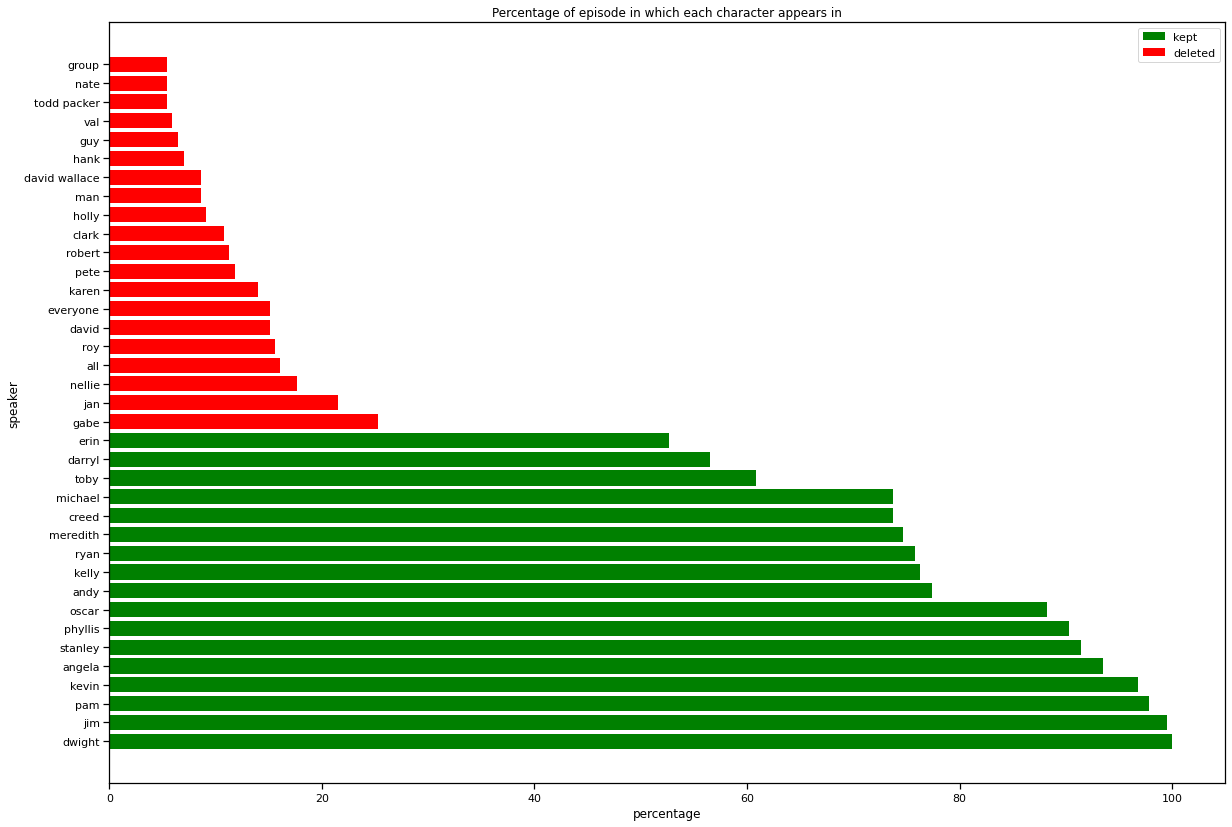

In [5]:
kept = ep_per.head(17)
deleted = ep_per.loc[17:]

fig = plt.figure(figsize = (20, 14))
#  Bar plot
plt.barh(kept.speaker , kept.percentage, color ='green', label = 'kept')
plt.barh(deleted.speaker , deleted.percentage, color ='red', label = 'deleted')
plt.legend()
plt.xlabel("percentage")
plt.ylabel("speaker")
plt.title("Percentage of episode in which each character appears in")
plt.show()

##### 2.1.1.2 Scenes percentage by character 

In [6]:
#percentage of scenes they appear in 
sc_per = scripts[['season_ep_scene','speaker','id']].groupby(['season_ep_scene','speaker']).count().reset_index()
sc_per[['id']]=1
sc_per = sc_per.groupby('speaker').sum().sort_values(by = 'id',ascending = False).reset_index().rename(columns={'id':'num_scenes'})
sc_per['percentage'] = round(sc_per['num_scenes']/tot_scenes,3)*100
sc_per = sc_per[sc_per['percentage']>0.5][['speaker','percentage']]


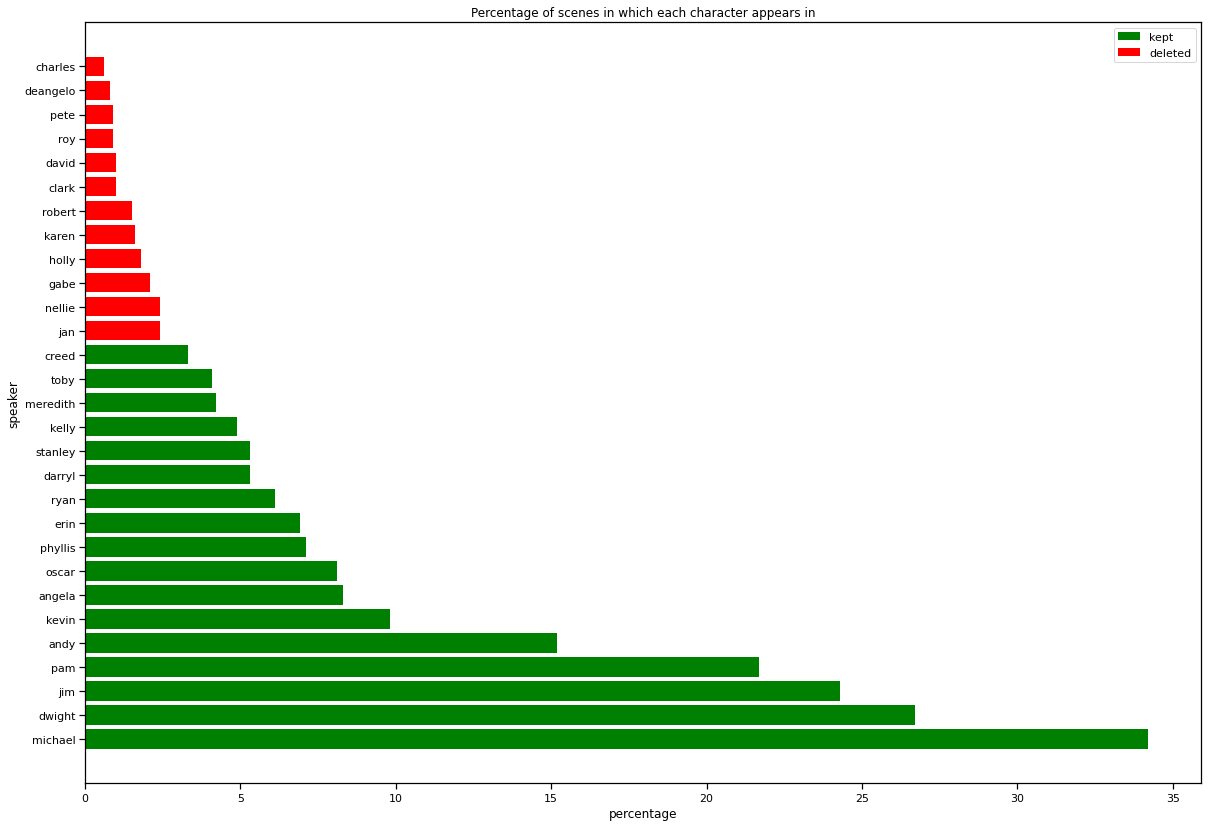

In [7]:
kept = sc_per.head(17)
deleted = sc_per.loc[17:]

fig = plt.figure(figsize = (20, 14))
#  Bar plot
plt.barh(kept.speaker , kept.percentage, color ='green', label = 'kept')
plt.barh(deleted.speaker , deleted.percentage, color ='red', label = 'deleted')
plt.legend()
plt.xlabel("percentage")
plt.ylabel("speaker")
plt.title("Percentage of scenes in which each character appears in")
plt.show()

In [8]:
main_ep_per = ep_per[ep_per['percentage']>50][['speaker','percentage']]
main_ch = main_ep_per.speaker.to_list() 

##### 2.1.1.3 Scripts: Percentage of lines by season and by character 

In [9]:
s = scripts.groupby(['season','speaker']).count()[['id']].reset_index().rename(columns={'id':'speaker_scenes'})
tot_scenes_by_season = scripts.groupby('season').count()[['id']].reset_index().rename(columns={'id':'tot_scenes'})

#f.join(tot_scenes_by_season, on = 'season')
seas_eval = s.merge(tot_scenes_by_season, on = 'season' )
seas_eval['prop_scenes'] = round(seas_eval['speaker_scenes']/seas_eval['tot_scenes'],3)*100
seas_eval = seas_eval[seas_eval['speaker'].isin(main_ch)][['speaker','season','prop_scenes']].reset_index(drop=True)

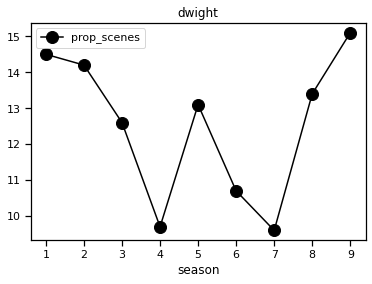

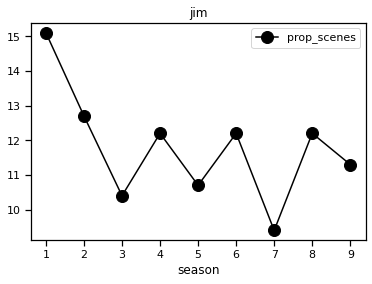

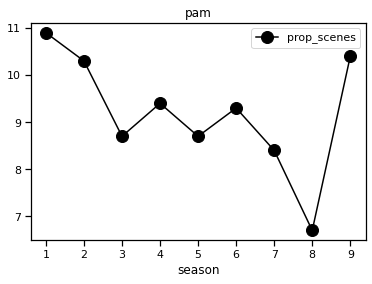

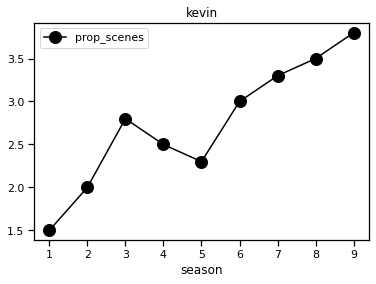

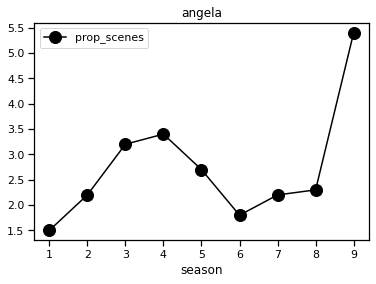

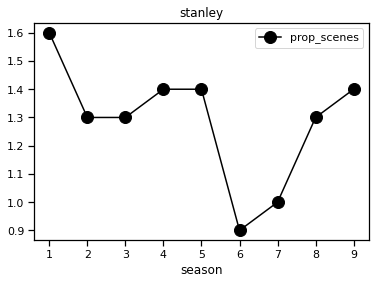

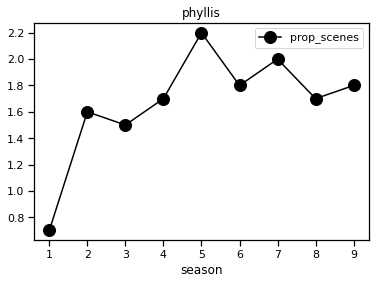

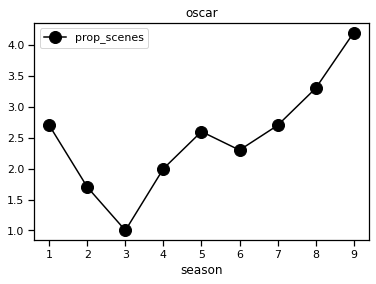

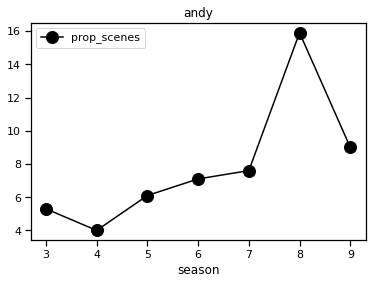

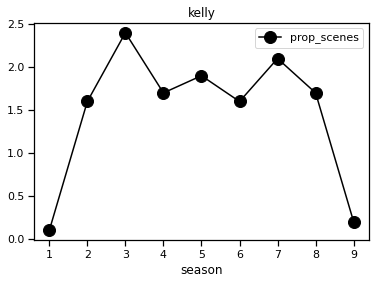

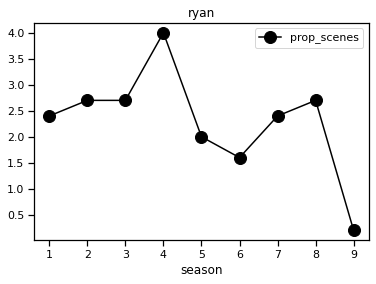

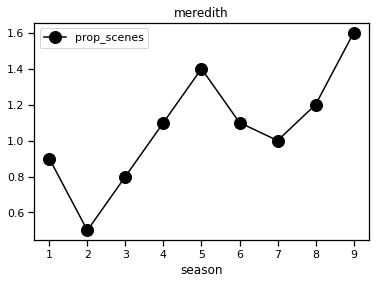

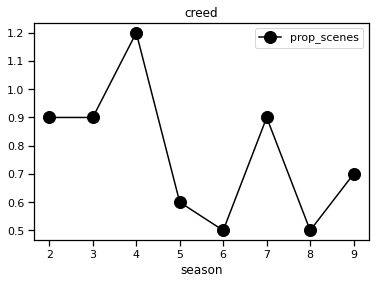

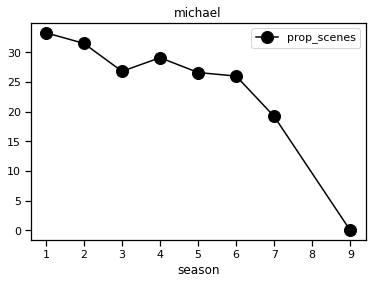

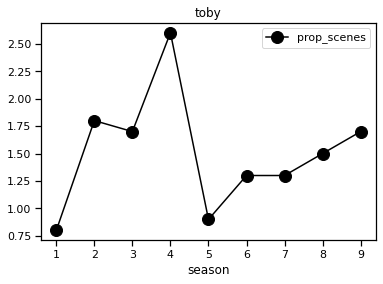

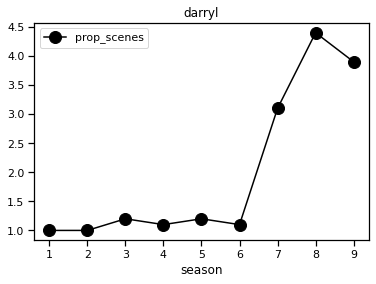

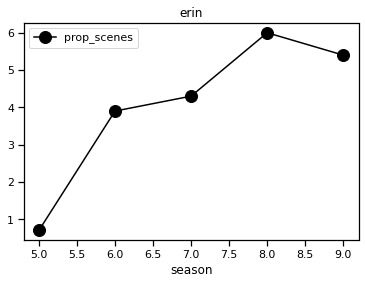

In [10]:
for i in range(len(main_ch)):
    
    ch = seas_eval[seas_eval['speaker']==main_ch[i]]
    ch.plot(x = 'season',y= 'prop_scenes', color = 'black', marker='o', markerfacecolor='black', markersize=12)
    plt.title(main_ch[i])

<div class="alert alert-block alert-success">
2.1.1 Scripts: Main character evaluation 

Main characters have been defined as the ones who appear in over 50% of the episodes. Graphic representation helps us in understanding why I have made this choice. It is possible to notice a clear difference between the character 'Erin' and 'Gabe' in the number of episodes they appear in. Furthermore, this criteria to divide the characters makes sense also by analyzing the specific number of lines that are pronounced by each character. 
To better understand the character importance, the number of scenes in which each character appears during the nine seasons has been evaluated. The results are evaluable through graphic visualization. 

From the beginning, over 700 characters, we will focus our analysis just on the 17 most present ones. These will be defined **main_ch** variable.

--- 

#### 2.1.2 Reviews analysis 
To evaluate the reviews, these have been defined using the score given by each reviewer and categorizing them as:
- Bad: score less than 5;
- Neutral: score between 5 and 6;
- Good: score over or equal to 7.

In [11]:
reviews['sentiment'] = 'good'
reviews.loc[(reviews['Rating'] > 0) & (reviews['Rating'] < 5 ), 'sentiment'] = 'bad'
reviews.loc[(reviews['Rating'] >= 5) & (reviews['Rating'] < 7 ), 'sentiment'] = 'neutral'

In [12]:
# general analysis on the number of reviews and the three categories 
# also by season expressing them in percentage 

In [13]:
plotdata = pd.DataFrame(reviews.groupby(['season','sentiment'])['sentiment'].count())
plotdata = plotdata.rename(columns={'sentiment':'count'})

Text(0, 0.5, 'Reviews count')

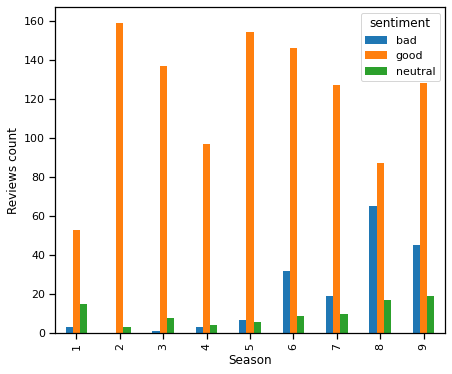

In [14]:
df_pivot = pd.pivot_table(
    plotdata, 
    values="count",
    index="season",
    columns="sentiment", 
)

# Plot a bar chart using the DF
ax = df_pivot.plot(kind="bar")
# Get a Matplotlib figure from the axes object for formatting purposes
fig = ax.get_figure()
# Change the plot dimensions (width, height)
fig.set_size_inches(7, 6)
# Change the axes labels
ax.set_xlabel("Season")
ax.set_ylabel("Reviews count")

In [15]:
df_pivot

sentiment,bad,good,neutral
season,,,
1,3.0,53.0,15.0
2,NaN,159.0,3.0
3,1.0,137.0,8.0
4,3.0,97.0,4.0
5,7.0,154.0,6.0
6,32.0,146.0,9.0
7,19.0,127.0,10.0
8,65.0,87.0,17.0
9,45.0,128.0,19.0


<div class="alert alert-block alert-success">
2.1.2 Review Analysis

It is possible to notice that the show's reviews are mainly positive, particularly until the show's seventh season. In the last, the main difference, as is evaluated in section 2.1.1.3 is that the main character 'Michael' is no longer in the tv show. This is probably the reason why the bad reviews started to grow up. 

### 2.2: Syntathic analysis 
In this section we are going to further evaluate how the words are presented in both dataframes and to do so we will proceed in the evaluation of the following topics, using in NER not preprocessed data and in POS preprocessed ones. 

#### 2.2.1 NER
The analysis wil be implemented by evalauting recognized organization and people in the reviews. The analysis will be performed on not preprocessed df because is important the usage of capital letters to actually recognize NE. 

In [175]:
nlp = spacy.load('en_core_web_sm')
entities_scr = [(entity.text, entity.label_) for sentence in scripts.line_text.to_list() for entity in nlp(sentence).ents]
entities_rew = [(entity.text, entity.label_) for sentence in reviews.Text.to_list() for entity in nlp(sentence).ents]
ent_num_scr = [entity.label_ for sentence in scripts.line_text.to_list() for entity in nlp(sentence).ents]
ent_num_rew = [entity.label_ for sentence in reviews.Text.to_list() for entity in nlp(sentence).ents]


In [192]:
def entity_df(entity_list,top_entities=30):
    
    ent = Counter(entity_list).most_common(top_entities)
    
    ent_text = []
    ent_lab = []
    count = []

    for i in range(top_entities):
        ent_text.append(ent[i][0][0]) #entity text 
        ent_lab.append(ent[i][0][1]) #entity label 
        count.append(ent[i][1]) # count

    ent_headvarname = ['entity text', 'entity label', 'count']
    zipped = zip(ent_text,ent_lab,count)
    ent_table = pd.DataFrame(zipped, columns = ent_headvarname)
    return ent_table

def entity_count(entity_list,ent_count=5):
    ent = Counter(entity_list).most_common(ent_count)
    ent_lab = []
    count = []
    for i in range(ent_count):
        ent_lab.append(ent[i][0])
        count.append(ent[i][1])
    
    ent_headvarname = ['entity label', 'count']
    zipped = zip(ent_lab,count)
    ent_table = pd.DataFrame(zipped, columns = ent_headvarname)
    return ent_table

In [195]:
entity_df(entities_scr)[:10]

,entity text,entity label,count
0,Michael,PERSON,1751
1,Jim,PERSON,1163
2,Dwight,PERSON,885
3,Pam,PERSON,699
4,Andy,PERSON,675
5,one,CARDINAL,569
6,two,CARDINAL,444
7,today,DATE,438
8,Kevin,PERSON,384
9,first,ORDINAL,375


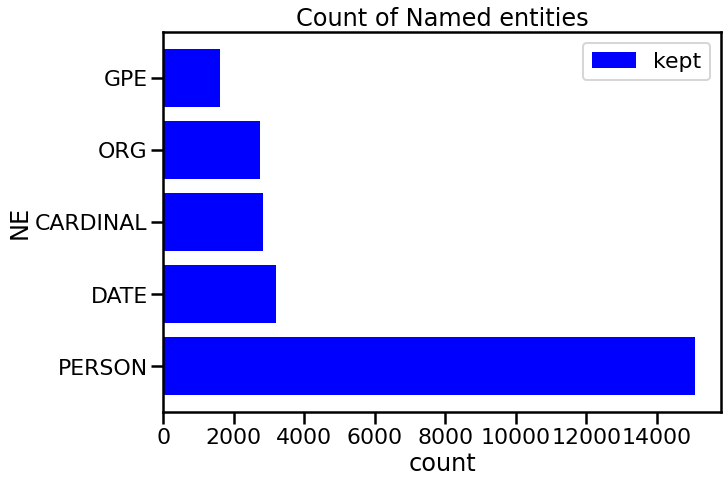

In [200]:
scr_NER = entity_count(ent_num_scr)
fig = plt.figure(figsize = (10, 7))
#  Bar plot
plt.barh(scr_NER['entity label'] , scr_NER['count'], color ='b', label = 'kept')
plt.legend()
plt.xlabel("count")
plt.ylabel("NE")
plt.title("Script: Count of Named entities")
plt.show()

In [201]:
entity_df(entities_rew)[:10]

,entity text,entity label,count
0,Michael,PERSON,1256
1,Jim,PERSON,789
2,Dwight,PERSON,713
3,Pam,PERSON,554
4,Andy,PERSON,420
5,Angela,PERSON,200
6,one,CARDINAL,186
7,Ryan,PERSON,171
8,first,ORDINAL,144
9,Oscar,PERSON,110


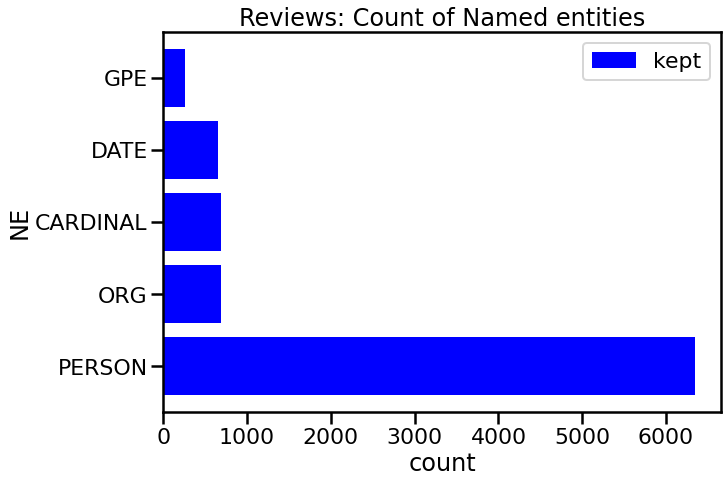

In [202]:
scr_NER = entity_count(ent_num_rew)
fig = plt.figure(figsize = (10, 7))
#  Bar plot
plt.barh(scr_NER['entity label'] , scr_NER['count'], color ='b', label = 'kept')
plt.legend()
plt.xlabel("count")
plt.ylabel("NE")
plt.title("Reviews: Count of Named entities")
plt.show()

<div class="alert alert-block alert-success">
2.2.1 NER

It is possible to notice that the most common Named Entities are 'PERSON' through the NER analysis. This happens in the lines because, being a tv-show, each document represents a little snippet of a conversation, and so it is necessary to refer to another speaker by using its name. Also, in the reviews, the most common are 'PERSON' by far, as the evaluation and the review is centered on the characters and what they do in each episode.

#### 2.2.2 POS 

In [219]:
reviews

,season,episode,Rating,Name,Date,Text,Useful,clean_text,clean_text_tokens,sentiment
0,1,1,7.0,ComedyFan2010,27 December 2018,The pilot episode of the great show The Office...,4/7,pilot episode great show office good_episode g...,"[pilot, episode, great, show, office, good_epi...",good
1,1,1,5.0,studioAT,17 October 2021,The American version of the UK show kicks off ...,2/6,american version show kick like pilot much sho...,"[american, version, show, kick, like, pilot, m...",neutral
2,1,1,8.0,Edvis-1997,24 October 2021,Wathcing it for the first time after 16 years ...,1/3,wathce first time year release still make laug...,"[wathce, first, time, year, release, still, ma...",good
3,1,1,9.0,MaxBorg89,16 January 2009,When it was first announced that NBC was going...,37/42,first announce nbc adapt bbc hit office americ...,"[first, announce, nbc, adapt, bbc, hit, office...",good
4,1,1,9.0,MrFilmAndTelevisionShow,17 February 2021,I've only watched the first episode of each se...,3/6,watch first episode series far brit think pref...,"[watch, first, episode, series, far, brit, thi...",good
...,...,...,...,...,...,...,...,...,...,...
1349,9,23,5.0,DragonFodder185,27 January 2021,I know I'm in the minority here but I guess I ...,18/50,know minority guess expect much michael_scott ...,"[know, minority, guess, expect, much, michael_...",neutral
1350,9,23,10.0,naregian,23 May 2013,We all know the show sort of jumped the shark ...,46/51,know show sort jump_shark michael leave think ...,"[know, show, sort, jump_shark, michael, leave,...",good
1351,9,23,1.0,Misha0809,18 February 2022,"So, what was the point of bringing Steve Carel...",0/8,point bring steve_carell back scene hardly tal...,"[point, bring, steve_carell, back, scene, hard...",bad
1352,9,23,10.0,saitanooj-87469,7 April 2020,This show is a stress relief for me particular...,3/3,show stress_relief particularly love every epi...,"[show, stress_relief, particularly, love, ever...",good


In [221]:
pos_scripts = [token.pos_ for sentence in scripts.clean_script.apply(str).to_list() for token in nlp(sentence)]
pos_reviews = [token.pos_ for sentence in reviews.clean_text.apply(str).to_list() for token in nlp(sentence)]

In [208]:
def pos_count(pos_list,pos_count=5):
    pos = Counter(pos_list).most_common(pos_count)
    pos_lab = []
    count = []
    for i in range(pos_count):
        pos_lab.append(pos[i][0])
        count.append(pos[i][1])
    
    pos_headvarname = ['pos label', 'count']
    zipped = zip(pos_lab,count)
    pos_table = pd.DataFrame(zipped, columns = pos_headvarname)
    return pos_table

In [222]:
pos_count(pos_scripts)

,pos label,count
0,NOUN,73676
1,PROPN,60739
2,VERB,56057
3,ADJ,29550
4,ADV,17860


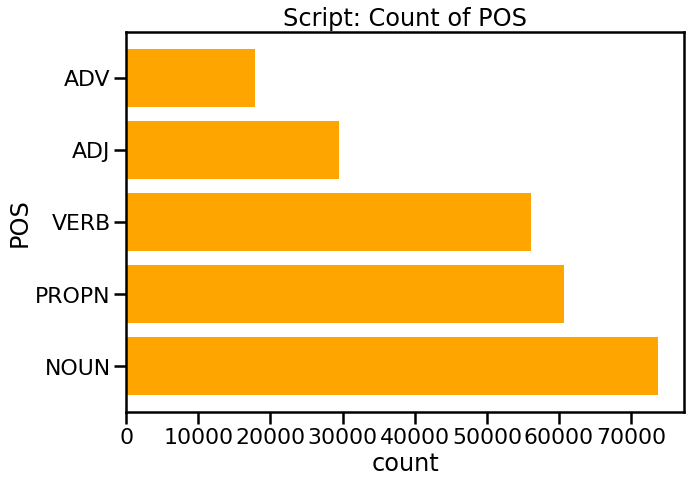

In [223]:
scr_pos = pos_count(pos_scripts)
fig = plt.figure(figsize = (10, 7))
#  Bar plot
plt.barh(scr_pos['pos label'] , scr_pos['count'], color ='orange')
plt.xlabel("count")
plt.ylabel("POS")
plt.title("Script: Count of POS")
plt.show()

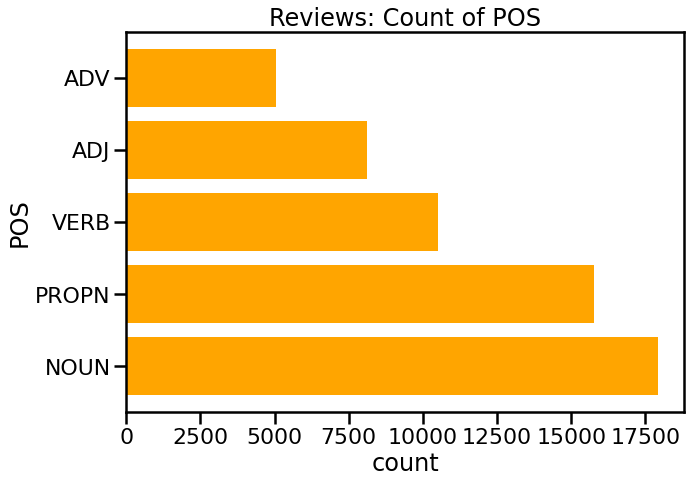

In [225]:
rew_pos = pos_count(pos_reviews)
fig = plt.figure(figsize = (10, 7))
#  Bar plot
plt.barh(rew_pos['pos label'] , rew_pos['count'], color ='orange')
plt.xlabel("count")
plt.ylabel("POS")
plt.title("Reviews: Count of POS")
plt.show()

<div class="alert alert-block alert-success">
2.2.2 POS

The Pos analysis on the clean text, respects what was already noticable in the NER analysis. In fact the main occurencies are in both cases related to noun, followed by proper nouns and verbs. 

### 2.3 Word frequencies, TFIDF and dimentionality reduction for visualization and topic modeling. 

#### 2.3.1 Word frequency counter - using count vectorizer 
Initially the analysis was performed on the whole 'clean script'. to make the analysis more meaningful, a new dataframe 'scripts_tfidf' has been defined.All the nan from the column clean_script have been removed and just the line scripts for the forehand defined main_ch will be analyzed. 

In [119]:
def top_words_df(word,count,ranks,top_words=20):
    ''' to build a df out of the countvectorizer results'''
    words_list = []
    count_list = []
    for i in ranks[-top_words:]:
        words_list.append(word[i])
        count_list.append(count[i])
    headVarName = ['Word','Count']
    zipped = zip(words_list,count_list)
    table = pd.DataFrame(zipped, columns = headVarName)
    return table

In [120]:
scripts.shape

(57580, 11)

In [121]:
# to use the count vectorizer will be necessary to remove all the instances of null values in the clean_script
null_clean = scripts[scripts.clean_script.isna() == 1]
mask3 = ~scripts.index.isin(null_clean.index)
scripts_tfidf = scripts.loc[mask3].reset_index(drop=True)
scripts_tfidf = scripts_tfidf[scripts_tfidf['speaker'].isin(main_ch)]

In [26]:
scripts_tfidf.shape

(43460, 11)

In [27]:
X_1 = CountVectorizer(min_df = 0.0, max_df = 1.0, stop_words = 'english')
D_1 = X_1.fit_transform(scripts_tfidf.clean_script)

count_1 = D_1.sum(axis=0).A1
ranks_1 = np.argsort(D_1.sum(axis=0).A1)

words_1 = X_1.get_feature_names()

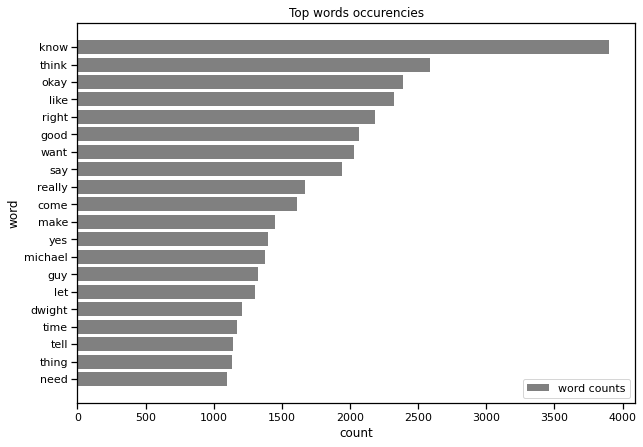

In [28]:
scr_top_words = top_words_df(words_1,count_1,ranks_1)

fig = plt.figure(figsize = (10, 7))
#  Bar plot
plt.barh(scr_top_words.Word , scr_top_words.Count, color = 'grey', label = 'word counts')
plt.legend()
plt.xlabel("count")
plt.ylabel("word")
plt.title("Top words occurencies")
plt.show()


### 2.3.2 Main characters: TFIDF + dimensionality reduction 

#### 2.3.2.1 Main characters: TFIDF

In [92]:

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2),
                                   analyzer='word', 
                                   min_df=0.001, 
                                   max_df=0.1, 
                                   stop_words='english', 
                                   sublinear_tf=True)

X = tfidf_vectorizer.fit_transform(scripts_tfidf.clean_script)

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1,2),
                             analyzer='word', 
                             min_df=0.001, 
                             max_df=0.1, 
                            stop_words='english')

X2 = vectorizer.fit_transform(scripts_tfidf.clean_script)

df = pd.DataFrame(data={'word': vectorizer.get_feature_names(), 
                        'tf': X2.sum(axis=0).A1, 
                        'idf': tfidf_vectorizer.idf_,
                        'tfidf': X.sum(axis=0).A1
                   }).sort_values(['tfidf', 'tf', 'idf']) # sort by TFIDF, then TF, then IDF

df.tail(10)


,word,tf,idf,tfidf
375,michael,1378,4.511039,715.505909
621,want,2027,4.190207,729.190198
503,say,1938,4.213392,797.047789
340,like,2321,4.049644,801.958013
238,good,2067,4.153440,807.797272
656,yes,1398,4.514899,853.091834
485,right,2184,4.080218,957.951228
584,think,2584,3.911932,961.631150
410,okay,2391,3.993457,1191.864090
318,know,3899,3.536393,1314.708234


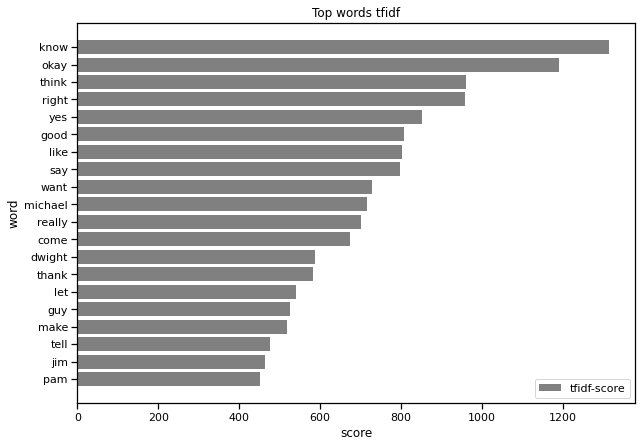

In [30]:
fig = plt.figure(figsize = (10, 7))
#  Bar plot
plt.barh(df.tail(20).word , df.tail(20).tfidf, color = 'grey', label = 'tfidf-score')
plt.legend()
plt.xlabel("score")
plt.ylabel("word")
plt.title("Top words tfidf")
plt.show()

<div class="alert alert-block alert-success">
2.3.2.1 Main characters: TFIDF

The results are not that different from the simple frequency count, in fact, we can find mainly verbs and the name of the characters in the show. It is not surprising given the kind of text that we are analyzing, but to gather some further information will be necessary to evaluate the single characters. 

##### 2.3.2.2 Main characters' lines: TFIDF Visualization

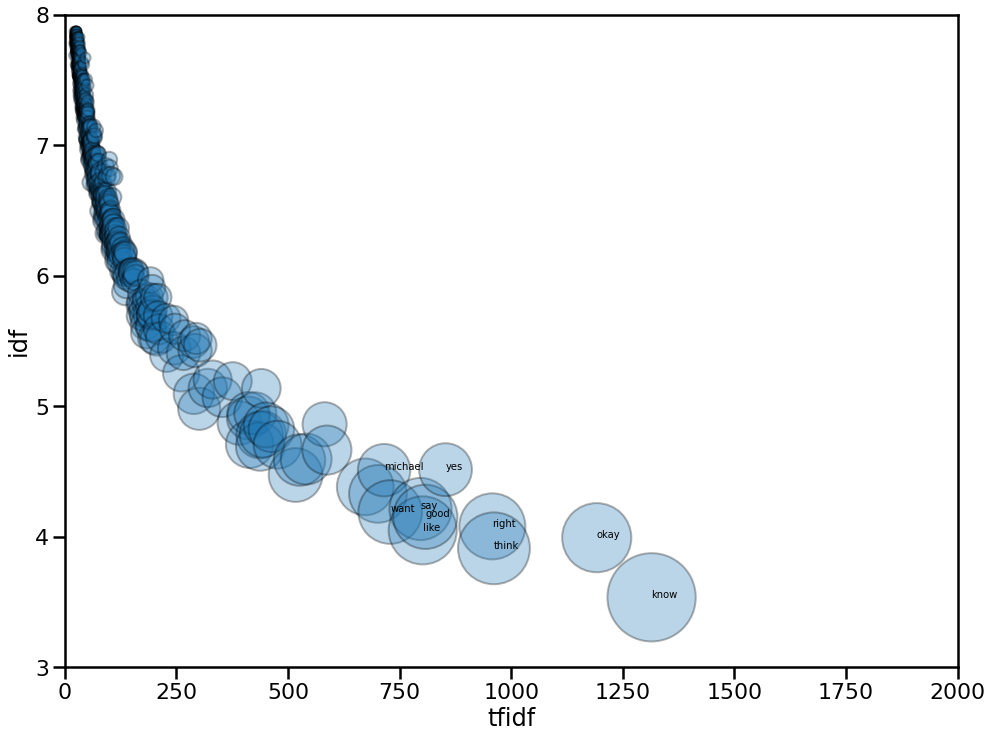

In [31]:
sb.set_context('poster')
%matplotlib inline
fig, ax = plt.subplots(figsize=(16, 12))

df['tf'] = df['tf']*2

df.plot.scatter(x='tfidf', y='idf', s='tf', ax=ax, 
                      alpha=0.3, 
                      edgecolor='k', 
                      ylim=(3,8), 
                      xlim=(0,2000)
                     );

for label, x, y in zip(df.iloc[-10:,0], df.iloc[-10:,3], df.iloc[-10:,2]):
    txt = plt.annotate(label,xy=(x, y), size = 10)

##### 2.3.2.3 Main characters: SVD 
This is mainly for TFIDF visualization, we will focus on topics in another section. 

In [25]:
sb.set_context('notebook')


def show_topics(A, vocabulary, topn=10):
    """
    find the top N words for each of the latent dimensions (=rows) in a matrix
    """
    topic_words = ([[vocabulary[i] for i in np.argsort(t)[:-topn-1:-1]]
                    for t in A])
    return [', '.join(t) for t in topic_words]


def plot_vectors(vectors, title='VIZ', labels=None, instance_id=None, dimensions=3, palette = 'spring'):
    """
    plot the vectors in 2 or 3 dimensions. 
    If labels are supplied, use them to color the data accordingly
    """
    # set up graph
    fig = plt.figure(figsize=(10,10))

    # create data frame
    df = pd.DataFrame(data={'x':vectors[:,0], 'y': vectors[:,1]})
    # add labels, if supplied
    if labels is not None:
        df['label'] = labels
    else:
        df['label'] = [''] * len(df)

    if instance_id is not None:
        df['instance_id'] = instance_id
    else:
        df['instance_id'] = [''] * len(df)

    # assign colors to labels
    cm = plt.get_cmap(palette) # choose the color palette
    n_labels = len(df.label.unique())
    label_colors = [cm(1. * i/n_labels) for i in range(n_labels)]
    cMap = colors.ListedColormap(label_colors)
        
    # plot in 3 dimensions
    if dimensions == 3:
        # add z-axis information
        df['z'] = vectors[:,2]
        # define plot
        ax = fig.add_subplot(111, projection='3d')
        frame1 = plt.gca() 
        # remove axis ticks
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels([])
        frame1.axes.zaxis.set_ticklabels([])

        # plot each label as scatter plot in its own color
        for l, label in enumerate(df.label.unique()):
            df2 = df[df.label == label]
            color_values = [label_colors[l]] * len(df2)
            ax.scatter(df2['x'], df2['y'], df2['z'], 
                       c=color_values, 
                       cmap=cMap, 
                       edgecolor='black', 
                       label=label, 
                       alpha=0.4, 
                       s=100)

        for x, y, z, i in zip(df.x, df.y, df.z, df.instance_id):
            ax.text(x, y, z, i, size=8)
      
    # plot in 2 dimensions
    elif dimensions == 2:
        ax = fig.add_subplot(111)
        frame1 = plt.gca() 
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels([])

        for l, label in enumerate(df.label.unique()):
            df2 = df[df.label == label]
            color_values = [label_colors[l]] * len(df2)
            ax.scatter(df2['x'], df2['y'], 
                       c=color_values, 
                       cmap=cMap, 
                       edgecolor='black', 
                       label=label, 
                       alpha=0.4, 
                       s=100)

        for x, y, i in zip(df.x, df.y, df.instance_id):
            ax.text(x, y, i, size=8)

            
    else:
        raise NotImplementedError()

    plt.title(title)
    plt.legend(loc='upper left')
    plt.show()


In [33]:
k = 10

svd = TruncatedSVD(n_components=k)
U = svd.fit_transform(X)
S = svd.singular_values_
V = svd.components_

terms = tfidf_vectorizer.get_feature_names()

In [34]:
show_topics(V, terms) 

['okay, know, right, think, yes, good, say, like, want, come',
 'know, right, think, yes, say, like, good, really, want, michael',
 'yes, right, thank, yes yes, good, jim, come, sir, big, say',
 'right, think, good, say, come, really, like, michael, let, thank',
 'think, say, michael, good, really, like, want, come, thank, dwight',
 'michael, say, thank, good, come, want, dwight, really, let, like',
 'michael, think, right, thank, talk, know, yes, okay, know think, jan',
 'good, thank, really, come, dwight, like, look, good good, god, pam',
 'thank, really, come, dwight, god, want, guy, like, pam, man',
 'like, really, want, come, dwight, make, guy, jim, let, mean']

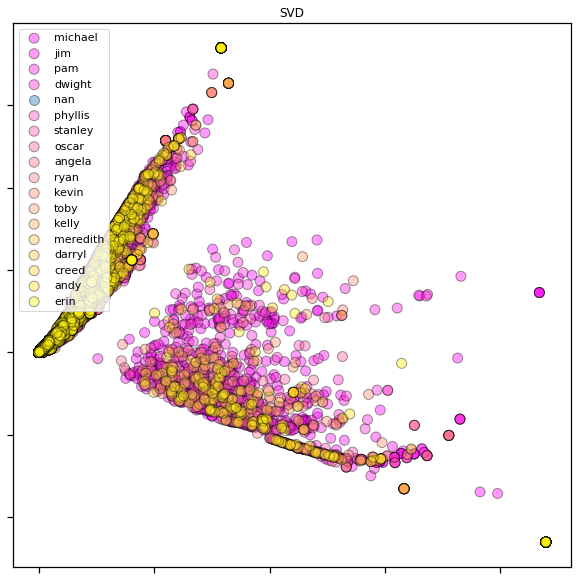

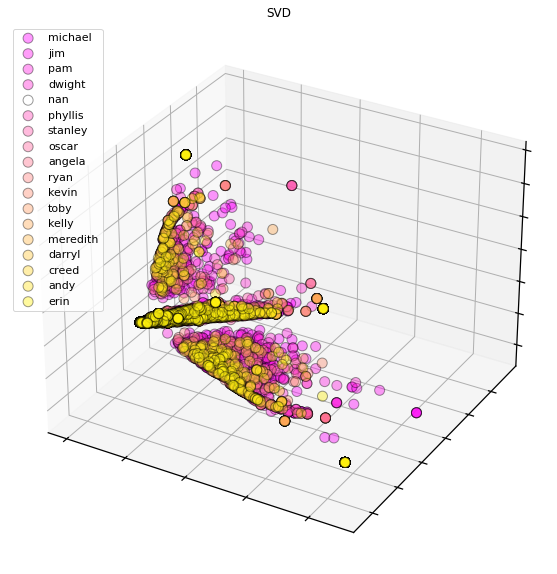

In [35]:
speakers = scripts_tfidf.speaker
low_dim_svd = TruncatedSVD(n_components=3)
Z = X
speakers = scripts_tfidf.speaker

low_dim_U = low_dim_svd.fit_transform(Z)

plot_vectors(low_dim_U, title='SVD', labels=speakers, dimensions= 2 )
plot_vectors(low_dim_U, title='SVD', labels=speakers, dimensions= 3 )

<div class="alert alert-block alert-success"> 2.1.3.1 - 2.1.3.3: Word frequencies, TFIDF and dimentionality reduction for visualization and topic modeling. 

We can notice that the main difference observable in the tfidf to the naive word frequencies count is that, even if often used verbs reach the highest scores in both cases, TFIDF can better capture the words related to the name of the characters. I have tried setting the parameters in many different ways to be able to exclude this effect, but I have noticed that even by setting extreme values of max_df ( max_df = 0.1, means that will be considered just words that are present in no more than 10% of the lines ) is not possible to mitigate this effect. 

The two bar plots report many common words, and the top-scoring ones are generally verbs. Even if the results could not seem reassuring, it is possible to cluster the words through dimensionality reduction, and by grouping them based on which character pronounces, it is possible to distinguish 3 clusters. The clearest cluster (yellow) that is possible to detect in the representation is the 'neutral character ones'. These characters are the politically correct ones. 
The other two seem to represent words that are generally shared among all characters. Even if there is no apparent difference in this case, we can notice that the yellow ones are more in proximity than the pink ones, as evident in the 2-D representation. 

--- 

#### 2.3.2.4 Pam analysis for word frequencies and TFIDF 
In this section our TfIdf analysis will be centered on a unique character to evaluate if it is possible to extrapolate trough this technique nuances with respect to 'pam'. 

In [36]:
pam_script = scripts_tfidf[scripts_tfidf['speaker']=='pam']
pam_script.head()
pam_script['clean_script']

7                                                well know
10                                                     fax
12                                                    tell
35                                                     one
37                      put garbage special filing cabinet
                               ...                        
52373                                            honeymoon
52379                      finally feel ready athlead grow
52381    jim jump back without skip beat come_back visi...
52385                                        thanks dwight
52416    think weird pick make documentary all'i think ...
Name: clean_script, Length: 4592, dtype: object

In [37]:
X_pam = CountVectorizer(min_df = 0.0, max_df = 1.0, stop_words = 'english')
D_pam = X_pam.fit_transform(pam_script.line_text.to_list())
count_pam = D_pam.sum(axis=0).A1
ranks_pam = np.argsort(D_pam.sum(axis=0).A1)
words_pam = X_pam.get_feature_names()

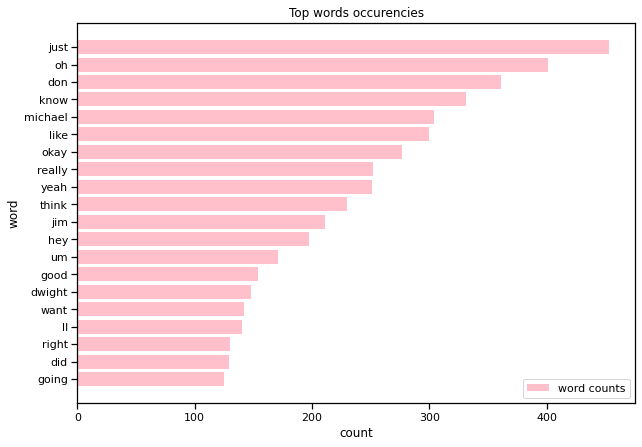

In [38]:
scr_top_words = top_words_df(words_pam,count_pam,ranks_pam)

fig = plt.figure(figsize = (10, 7))
#  Bar plot
plt.barh(scr_top_words.Word , scr_top_words.Count, color = 'pink', label = 'word counts')
plt.legend()
plt.xlabel("count")
plt.ylabel("word")
plt.title("Top words occurencies")
plt.show()

In [39]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1),
                                   analyzer='word', 
                                   min_df=0.001, 
                                   max_df=0.6,
                                   norm='l2',
                                   smooth_idf=True,
                                   sublinear_tf=True)

X = tfidf_vectorizer.fit_transform(pam_script.clean_script.to_list())



vectorizer = CountVectorizer(ngram_range=(1,1),
                             analyzer='word', 
                             min_df=0.001, 
                             max_df=0.6)

X2 = vectorizer.fit_transform(pam_script.clean_script.to_list())

df = pd.DataFrame(data={'word': vectorizer.get_feature_names(), 
                        'tf': X2.sum(axis=0).A1, 
                        'idf': tfidf_vectorizer.idf_,
                        'tfidf': X.sum(axis=0).A1
                   }).sort_values(['tfidf', 'tf', 'idf']) # sort by TFIDF, then TF, then IDF

df.tail(20)

,word,tf,idf,tfidf
112,come,138,4.541940,57.787167
239,god,86,5.050262,59.266948
246,great,124,4.644797,62.082230
408,one,180,4.395336,62.305879
479,right,130,4.580258,64.598744
165,dwight,148,4.490646,64.687805
240,good,167,4.395336,70.662861
649,yes,116,4.696090,70.904081
491,say,189,4.278997,73.081792
613,want,205,4.211933,74.141571


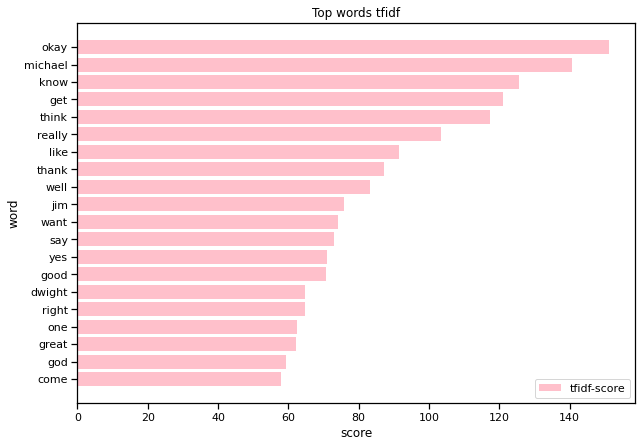

In [40]:
fig = plt.figure(figsize = (10, 7))
#  Bar plot
plt.barh(df.tail(20).word , df.tail(20).tfidf, color = 'pink', label = 'tfidf-score')
plt.legend()
plt.xlabel("score")
plt.ylabel("word")
plt.title("Top words tfidf")
plt.show()

--- 

In [105]:
### TFIDF BY GROUPING ALL THE LINES FOR EACH CHARACTER FOR EACH EPISODE. 
line_by_episode = scripts
line_by_episode = line_by_episode[line_by_episode.clean_script.isna()==False] # drop all reviews without text
line_by_episode['text_join'] = line_by_episode[['season','episode','clean_script','speaker']].groupby(['season','episode','speaker'])['clean_script'].transform(lambda x: ','.join(x))
line_by_episode = line_by_episode[['season','episode','text_join','speaker']].drop_duplicates()
line_by_episode.head()

<ipython-input-105-c4db0081d33b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  line_by_episode['text_join'] = line_by_episode[['season','episode','clean_script','speaker']].groupby(['season','episode','speaker'])['clean_script'].transform(lambda x: ','.join(x))


,season,episode,text_join,speaker
0,1,1,"right jim quarterly look good thing library,co...",michael
1,1,1,"tell could close,actually call,job speak clien...",jim
7,1,1,"well know,fax,tell,one,put garbage special fil...",pam
16,1,1,"shall play rum pump pum gift rum pump pum,whas...",dwight
29,1,1,"lunch would great,alright anything want add ag...",jan


In [43]:
df_pam = line_by_episode[line_by_episode['speaker']=='pam']

In [44]:
tfidf_vectorizer_pam2 = TfidfVectorizer(ngram_range=(1,1),
                                   analyzer='word', 
                                   min_df=0.001, 
                                   max_df=0.5,
                                   smooth_idf=True)

X_pam2 = tfidf_vectorizer_pam2.fit_transform(df_pam.text_join.to_list())


vectorizer_pam2 = CountVectorizer(ngram_range=(1,1),
                             analyzer='word', 
                             min_df=0.001, 
                             max_df=0.5)

X2_pam2 = vectorizer_pam2.fit_transform(df_pam.text_join.to_list())

df = pd.DataFrame(data={'word': vectorizer_pam2.get_feature_names(), 
                        'tf': X2_pam2.sum(axis=0).A1, 
                        'idf': tfidf_vectorizer_pam2.idf_,
                        'tfidf': X_pam2.sum(axis=0).A1
                   }).sort_values(['tfidf', 'tf', 'idf']) # sort by TFIDF, then TF, then IDF

df.tail(20)

,word,tf,idf,tfidf
1868,need,92,2.149043,4.182615
1251,guy,92,2.115142,4.208684
2844,thing,99,1.975380,4.236334
2628,sorry,96,2.019831,4.343638
1651,look,90,2.082352,4.361257
2869,time,111,1.891998,4.512749
675,could,108,1.960991,4.536320
439,call,88,2.082352,4.539634
3159,would,110,1.827460,4.697012
3188,yes,116,1.840038,4.938853


<div class="alert alert-block alert-success">
2.3.2.4 Pam analysis for word frequencies and TFIDF 

For this single character i have tried to reduce the number of lines, by grouping them for each character in each episode. The idea was to reduce the df, but it was not able to capture trough TfIdf particularly meaningful words.

#### 2.3.2.5 reviews TFIDF 
Being the Number of documents in the reviews much less, i have decided to increment the number of min_df to be able to better visualize the results and to try to grasp more important words. 

In [18]:
tfidf_vectorizer_rew = TfidfVectorizer(ngram_range=(1,2),
                                   analyzer='word', 
                                   min_df=0.001, 
                                   max_df=0.6, 
                                   stop_words='english', 
                                   sublinear_tf=True)

X_rew = tfidf_vectorizer_rew.fit_transform(reviews.clean_text)

from sklearn.feature_extraction.text import CountVectorizer

vectorizer_rew = CountVectorizer(ngram_range=(1,2),
                             analyzer='word', 
                             min_df=0.001, 
                             max_df=0.6, 
                            stop_words='english')

X2_rew = vectorizer_rew.fit_transform(reviews.clean_text)

df_rew = pd.DataFrame(data={'word': vectorizer_rew.get_feature_names(), 
                        'tf': X2_rew.sum(axis=0).A1, 
                        'idf': tfidf_vectorizer_rew.idf_,
                        'tfidf': X_rew.sum(axis=0).A1
                   }).sort_values(['tfidf', 'tf', 'idf']) # sort by TFIDF, then TF, then IDF



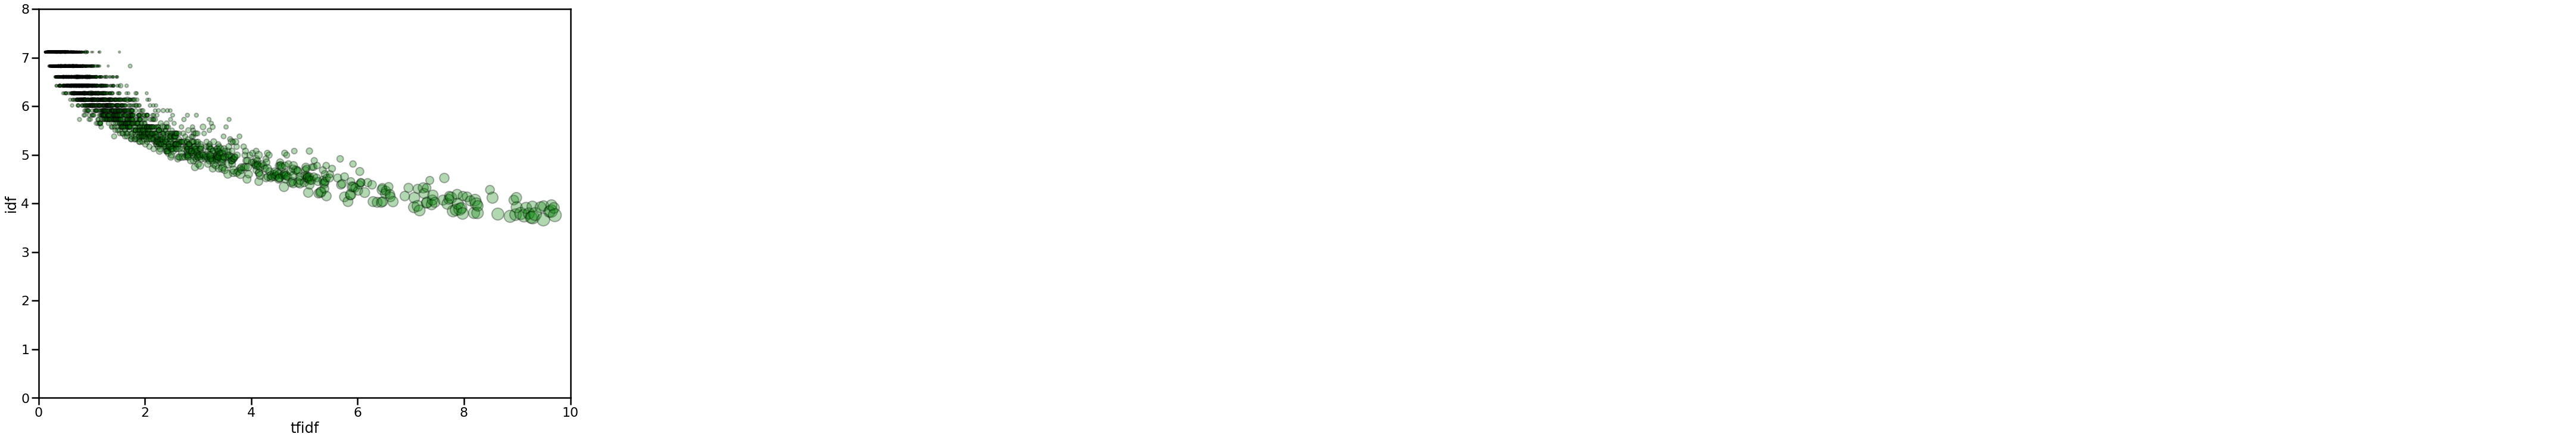

In [21]:
sb.set_context('poster')
%matplotlib inline

fig, ax = plt.subplots(figsize=(16, 12))

df_rew['tf'] = df_rew['tf']*2

df_rew.plot.scatter(x='tfidf', 
                y='idf', 
                s='tf', 
                ax=ax, 
                alpha=0.3, 
                color = 'g',
                edgecolor='k', 
                ylim=(0,8), 
                xlim=(0,10)
                     );

for label, x, y in zip(df_rew.iloc[-10:,0], df_rew.iloc[-10:,3], df_rew.iloc[-10:,2]):
    txt = plt.annotate(label,xy=(x, y), size = 10)

#### 2.3.2.6 Reviews: SVD for visualization

In [70]:
k = 9

svd = TruncatedSVD(n_components=k)
U = svd.fit_transform(X_rew)
S = svd.singular_values_
V = svd.components_

terms = tfidf_vectorizer_rew.get_feature_names()

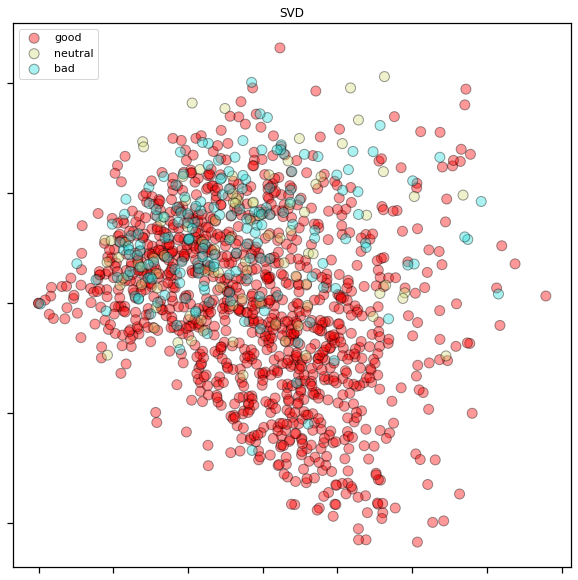

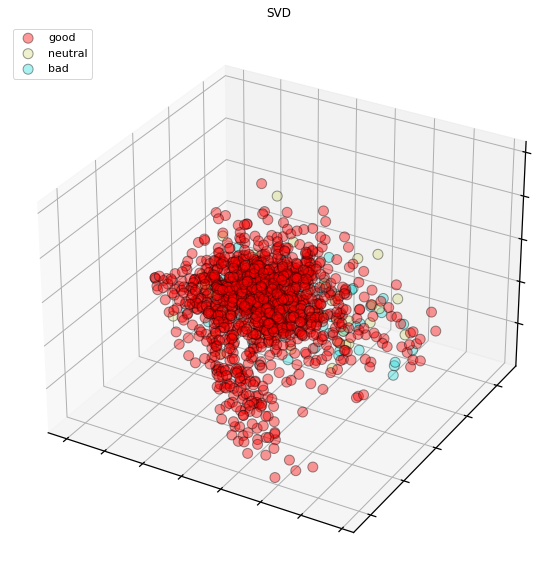

In [71]:
sentiment = reviews.sentiment 
low_dim_svd = TruncatedSVD(n_components=3)
Z = X_rew
low_dim_U = low_dim_svd.fit_transform(Z)
plot_vectors(low_dim_U, title='SVD', labels=sentiment, dimensions= 2, palette = 'rainbow_r')
plot_vectors(low_dim_U, title='SVD', labels=sentiment, dimensions= 3, palette = 'rainbow_r')

#### 2.3.2.7 Reviews: SVD for topic modeling 

In [39]:
show_topics(V, terms, topn = 5) 

['michael, dwight, jim, office, like',
 'season, character, watch, series, funny',
 'love, great, good, great episode, fun',
 'andy, erin, nellie, character, story',
 'love, watch, time, love episode, watch episode',
 'great, laugh, season, dwight, office',
 'pam, jim, character, pam jim, good',
 'good_episode, funny, jim, good_episode good_episode, good_episode office',
 'bad, series, good_episode, entire, entire series']

1. Main characters 
2. General words related to  tv-series 
3. Positive adjectives to describe the series 
4. Secondary characters 
5. Probably suggestion words 
6. Positive adjectives to describe the series 
7. Jim Pam love relationship 
8. Positive adjectives to describe the series 
9. Positive adjectives to describe the series 


#### 2.3.2.8 Reviews: SVD for topic modeling

In [113]:
k = 9

nmf = NMF(n_components=k, init='nndsvd', random_state=0)

W = nmf.fit_transform(X_rew)
H = nmf.components_
show_topics(H, terms)

/Users/valedipalo/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


['michael, jim, say, pam, tell, dwight, ask, office, come, want',
 'season, character, office, good, writer, episode season, michael_scott, cast, start, end',
 'great, dwight, love, good, michael, fun, great episode, jim, pretty, story',
 'andy, erin, nellie, character, angela, annoying, pete, terrible, ruin, dwight',
 'watch, funny, love, watch episode, really, time, 00, episode funny, favorite, hope',
 'like, really, feel, character, michael, episode like, scene, end, think, like michael',
 'laugh, funniest, time, funniest episode, make laugh, hard, make, laugh hard, comedy, episode make',
 'good_episode, good_episode good_episode, good_episode office, entire, entire series, probably good_episode, probably, good_episode season, series, good_episode entire',
 'bad, bad episode, series, episode series, idea, main, feel bad, episode bad, main idea, really bad']

<div class="alert alert-block alert-success"> 
    2.1.3.5-2.1.3.8 tfidf on reviews 

It is also possible to find some exciting clusters by evaluating the tfidf 3d representation through SVD. In particular, we can see that words associated with good review are clustered together, forming the big red cluster in the representation. This is not unexpected because of the high number of positive reviews. This is a good hint and why we will proceed with the clustering evaluation of the reviews. In section 2.1.3.7, I tried to extract a topic for each latent dimension. Some dimensions seem easy to label, i.e. [''season, character, watch, series, funny']. I used as many latent dimensions as I used to cluster revies to be consistent, and the choice of 5 top words relies on the fact that four was too few while six started to create duplicates.

In the NMF decomposition, we also get interesting latent topics; most of them are positive ones, even if we can notice that the last is also able to capture words related to negative reviews.


## 2.4 Word2Vec 

Our analysis will use word2vec concerning words that assume a specific meaning in the scripts and the reviews. Given the specificities of the dataset, the tuning part required some time. In fact, to obtain accurate results, one of the critical parameters has been 'sample'. It has to be set low to train the model properly.

In [4]:
cores = multiprocessing.cpu_count()
sentences = [str(line).split() for line in scripts['clean_script']]

### 2.4.1 Word2vec Implementation: is Michael or Michael Scott the manager? 

In [5]:
w2v_model = Word2Vec(min_count=20,
                     window=8,
                     vector_size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1,
                     seed = 1 )

w2v_model.build_vocab(sentences, progress_per=10000)

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(2168671, 8065920)

In [6]:
w2v_model.wv.most_similar('michael')

[('approve', 0.9684092402458191),
 ('conversation', 0.9638440012931824),
 ('immediately', 0.9596025943756104),
 ('promotion', 0.9587278962135315),
 ('david', 0.9573744535446167),
 ('performance', 0.9564417600631714),
 ('impression', 0.9548860788345337),
 ('follow', 0.9542887806892395),
 ('presentation', 0.9527069926261902),
 ('pitch', 0.9525339603424072)]

In [60]:
w2v_model.wv.most_similar('michael_scott')

[('regional_manager', 0.9566776156425476),
 ('paper_company', 0.9480229020118713),
 ('introduce', 0.9337173700332642),
 ('dwight_schrute', 0.9236044883728027),
 ('david_wallace', 0.9194542169570923),
 ('dunder_mifflin', 0.9185448884963989),
 ('ceo', 0.9030573964118958),
 ('jim_halpert', 0.8952937126159668),
 ('manager', 0.8902847170829773),
 ('scranton', 0.8872278928756714)]

In [61]:
w2v_model.wv.similarity('michael', 'manager')

0.72933114

In [62]:
w2v_model.wv.similarity('michael_scott', 'manager')

0.8902847

In [63]:
w2v_model.wv.doesnt_match(['jim', 'pam', 'dwight'])

'dwight'

In [64]:
w2v_model.wv.most_similar('oscar')

[('angela', 0.9376584887504578),
 ('senator', 0.931634783744812),
 ('whoa', 0.9263932108879089),
 ('crush', 0.9254741668701172),
 ('bang', 0.9247880578041077),
 ('kevin', 0.9247733950614929),
 ('relax', 0.9245406985282898),
 ('offensive', 0.9242857694625854),
 ('stanley', 0.9230517745018005),
 ('meredith', 0.9159940481185913)]

In [65]:
w2v_model.wv.most_similar(positive=["senator"])

[('affair', 0.9714789986610413),
 ('boyfriend', 0.9648842215538025),
 ('rude', 0.9492592811584473),
 ('engage', 0.9491071105003357),
 ('handsome', 0.9483879208564758),
 ('awkward', 0.9473068118095398),
 ('surprised', 0.9468024969100952),
 ('usually', 0.9467454552650452),
 ('incredibly', 0.94545978307724),
 ('stop_stop', 0.9449205994606018)]

<div class="alert alert-block alert-success">
2.3.1 Conclusion

Is possible to notice that trough the usage of Word2Vec we are able to capture some of the nuances in the characters and their characteristics. The dataset is the Office' lines of dialogue; therefore, when we look at the most similar words from "michael" we do not necessary get his collegues, personality traits, or even his most quotable words. No, we get what other characters (as Michael does not often refers to himself at the 3rd person) said along with "michael", such as specific request to do to him ("promotion", "permission"). If we refer to Michael in a more formal way evaluating the similiarities with michael_scott, we can see that also the words associated to him are more formal and this is due to when the character is referred by name and surname in more formal occasion. To prove it, the similiarity score between michael/michael_scott and the word 'manager' has been evaluated and we can notice that it generally increases. 

Furthermore, with the doesnt_match method we are able to capture the strong relationship between jim and pam.

Other interesting nuances are revealed when we refer to character as 'toby' or 'senator' which will be better evaluated in the next section. 

### 2.4.2 t-SNE for Word2Vec Visualization : Exploring the Love triangle Angela-Oscar-Senator
t-SNE is a non-linear dimensionality reduction algorithm that attempts to represent high-dimensional data and the underlying relationships between vectors in a lower-dimensional space. We will use it to represent the word2vec similiarities with respect to the term 'Senator','Oscar' and 'Angela. 

In [90]:
def display_closestwords_tsnescatterplot(model, word,n, palette='viridis_r'):
    
    arr = np.empty((0,300), dtype='f')
    word_labels = [word]

    # get close words
    close_words = model.wv.most_similar([word], topn = n)
    
    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([model.wv[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model.wv[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    plt.scatter(x_coords, y_coords, c=np.arange(0,len(close_words)+1), cmap=palette)#, cmap=cMap)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()-50, x_coords.max()+150)
    plt.ylim(y_coords.min()-50, y_coords.max()+50)
    plt.title('MOST SIMILAR WORDS TO {}'.format(word))
    plt.show()

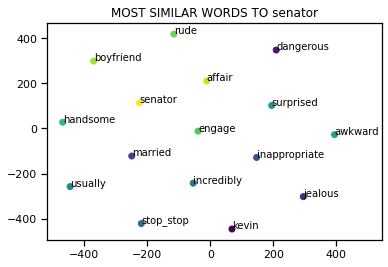

In [91]:
display_closestwords_tsnescatterplot(w2v_model,'senator',15)

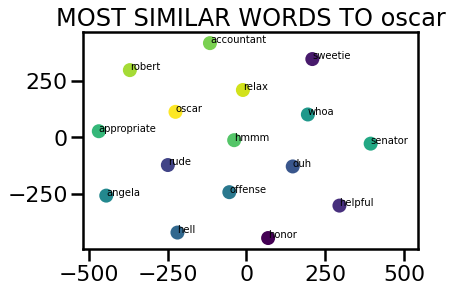

In [301]:
display_closestwords_tsnescatterplot(w2v_model,'oscar',15)

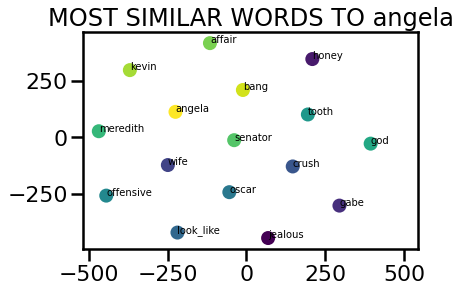

In [302]:
display_closestwords_tsnescatterplot(w2v_model,'angela',15)

<div class="alert alert-block alert-success"> 2.4.2 t-SNE for Word2Vec Visualization

It is possible to notice also trough visualization that the word 'senator' is associated to words as 'boyfriend', 'married', 'affair'. This is because he is having an affair with one of the main character of the show: Angela. Angela is very proud that she is dating a state senator, but, actually, he is a shady character. As will be revealed in Season 9 is secretely homosexual and has the relationship with Angela just for the Press and to safeguard his political interests, while having an 'affair' with Oscar. This could explain why more far are present words as 'surprised', 'incredibly' and 'awkward'. 

Oscar is a much more 'appropriate' character, and we can find many referencies to what he does ('accountant') and how he is ('helpful') according to the other characters. We can find also a strong similiarity with the word senator even if 'Oscar' name is mainly associated to more general characteristics. 

### - Word2Vec average implementation

In [233]:

sentences = [str(line).split() for line in scripts['clean_script']]

w2v_model1 = Word2Vec(min_count=20,
                     window=8,
                     vector_size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1,
                     seed = 1 )

w2v_model1.build_vocab(sentences, progress_per=10000)

w2v_model1.train(sentences, total_examples=w2v_model1.corpus_count, epochs=30, report_delay=1)

w2v_model2 = Word2Vec(min_count=20,
                     window=8,
                     vector_size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1,
                     seed = 2 )

w2v_model2.build_vocab(sentences, progress_per=10000)

w2v_model2.train(sentences, total_examples=w2v_model2.corpus_count, epochs=30, report_delay=1)

w2v_model3 = Word2Vec(min_count=20,
                     window=8,
                     vector_size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1,
                     seed = 3 )

w2v_model3.build_vocab(sentences, progress_per=10000)

w2v_model3.train(sentences, total_examples=w2v_model3.corpus_count, epochs=30, report_delay=1)

w2v_model4 = Word2Vec(min_count=20,
                     window=8,
                     vector_size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1,
                     seed = 4 )

w2v_model4.build_vocab(sentences, progress_per=10000)

w2v_model4.train(sentences, total_examples=w2v_model4.corpus_count, epochs=30, report_delay=1)

w2v_model5 = Word2Vec(min_count=20,
                     window=8,
                     vector_size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1,
                     seed = 5 )

w2v_model5.build_vocab(sentences, progress_per=10000)

w2v_model5.train(sentences, total_examples=w2v_model5.corpus_count, epochs=30, report_delay=1)

(2167519, 8065920)

In [234]:
emb_1 = np.array([w2v_model1.wv.get_vector(str(n)) for n in w2v_model1.wv.key_to_index])
emb_2 = np.array([w2v_model2.wv.get_vector(str(n)) for n in w2v_model2.wv.key_to_index])
emb_3 = np.array([w2v_model3.wv.get_vector(str(n)) for n in w2v_model3.wv.key_to_index])
emb_4 = np.array([w2v_model4.wv.get_vector(str(n)) for n in w2v_model4.wv.key_to_index])
emb_5 = np.array([w2v_model5.wv.get_vector(str(n)) for n in w2v_model5.wv.key_to_index])

pd.DataFrame(emb_1+emb_2+emb_3+emb_4+emb_5/5,index = w2v_model1.wv.key_to_index).T

,nan,know,get,think,well,okay,like,right,good,want,...,pump,spray,industry,perfectly,accord,suffer,heck,appointment,bull,closet
0,0.005886,-0.022739,-0.093120,0.017935,-0.087605,-0.221814,0.223091,-0.104416,-0.065624,-0.011400,...,-0.091039,0.019524,-0.118198,-0.010726,-0.043519,0.028855,0.005320,-0.128639,0.028693,0.181892
1,-0.000912,0.232782,-0.036129,0.176896,-0.022789,0.119179,-0.102521,0.145149,-0.004836,0.121776,...,0.021410,-0.238705,-0.172562,0.103034,-0.154552,-0.152127,-0.082470,-0.073269,-0.103976,-0.047921
2,-0.001134,0.102661,0.164458,0.051409,0.222344,0.338111,-0.060592,0.199981,0.250275,0.074060,...,0.233948,0.088556,0.055206,0.105448,0.190487,0.055712,0.139314,0.330558,0.165664,0.073958
3,0.000391,0.235183,0.248409,0.134005,0.213916,0.329185,0.141752,0.294096,0.101656,0.300145,...,0.321548,0.028548,0.123826,0.110103,0.207571,0.302877,0.292442,0.266796,0.281756,0.260342
4,-0.002905,0.296515,0.264153,0.331676,0.211157,0.229208,0.106625,0.137142,0.156041,0.281602,...,-0.021681,0.144177,0.042224,0.111934,-0.102850,0.053134,0.130709,-0.024380,0.150436,0.069520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.005110,0.197314,0.120505,0.015513,0.080817,-0.035305,0.410091,0.052971,0.065352,-0.031798,...,0.098297,0.153303,0.038856,0.019358,0.220931,0.159534,0.089177,-0.086588,0.098648,0.112382
296,0.002863,0.390543,0.069407,0.445785,0.170895,0.098867,0.122028,0.126471,0.298418,0.169396,...,0.000758,-0.144066,-0.103593,0.190325,-0.201756,-0.293395,-0.098386,-0.027663,0.071721,0.027652
297,-0.004527,-0.691202,-0.719649,-0.837292,-0.687629,-0.616638,-0.790098,-0.520120,-0.570366,-0.765341,...,-0.523877,-0.494704,-0.527191,-0.645613,-0.603040,-0.530778,-0.645463,-0.663018,-0.556250,-0.677441
298,-0.004104,-0.206808,0.011047,-0.239627,-0.262133,-0.048436,-0.304648,-0.092924,-0.331384,0.035167,...,-0.084667,-0.021252,-0.372339,-0.170207,-0.264729,-0.121821,-0.112231,-0.100755,-0.118382,-0.058394


---- 

### 2.5 Doc2Vec 

TF-IDF is a good starting point but it has major limitations. Since it is a bag-of-words representation, it doesn’t keep the words in order and doesn’t account for much semantic meaning. Doc2Vec on the other hand is able to detect relationships among words and understand the semantics of the text. Trough it we will be able to evaluate on a deeper level who are the most similiar characters. 

Reviews we will be classified in three classes (good,neutral,negative) meanwhile in scripts we will just keep the lines of the characters that are considered as main ones according to previous analysis. 

In [75]:
scr_main_ch = scripts[scripts['speaker'].isin(main_ch)][['line_text', 'clean_script', 'speaker','season']]

In [55]:
scr_main_ch

,line_text,clean_script,speaker,season
0,All right Jim. Your quarterlies look very good...,right jim quarterly look good thing library,michael,1
1,"Oh, I told you. I couldn't close it. So...",tell could close,jim,1
2,So you've come to the master for guidance? Is ...,come master guidance say grasshopper,michael,1
3,"Actually, you called me in here, but yeah.",actually call,jim,1
4,"All right. Well, let me show you how it's done.",right well let show,michael,1
...,...,...,...,...
43464,Is that right?,right,pam,7
43465,I think you two should meet.,think two meet,creed,7
43466,"Well, okay!",well okay,pam,7
43467,Hey Jordana! Patch my ninth- and fourth-bigges...,jordana patch ninth- fourth big client together,creed,7


In [76]:
corpus = []
for row in scr_main_ch.iterrows():
    text = row[1].clean_script
    label = row[1].speaker
    corpus.append(TaggedDocument(words=str(text).split(), 
                                 tags=[str(label)]))

d2v_model = Doc2Vec(vector_size=300, 
                    window=8,
                    hs=0,
                    sample=6e-5,
                    negative=20,
                    min_count=20,
                    workers=cores-1,
                    epochs=30,
                    dm=0, 
                    dbow_words=1)

d2v_model.build_vocab(corpus)

d2v_model.train(corpus, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)

In [88]:
similar_docs = d2v_model.dv.most_similar('michael')
print(similar_docs)

[('dwight', 0.3375427722930908), ('jim', 0.31145453453063965), ('andy', 0.30429401993751526), ('pam', 0.2653195261955261), ('toby', 0.2629633843898773), ('erin', 0.26248037815093994), ('ryan', 0.2586633265018463), ('kevin', 0.2584800720214844), ('oscar', 0.25010964274406433), ('angela', 0.23755434155464172)]


In [83]:
def display_closestwords_tsnescatterplot(model, char, n, palette='viridis_r'):
    
    arr = np.empty((0,300), dtype='f')
    char_labels = [char]

    # get close char
    close_char = model.dv.most_similar([char], topn = n)
    
    # add the vector for each of the closest char to the array
    arr = np.append(arr, np.array([model.dv[char]]), axis=0)
    for wrd_score in close_char:
        wrd_vector = model.dv[wrd_score[0]]
        char_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    plt.scatter(x_coords, y_coords, c=np.arange(0,len(close_char)+1), cmap=palette)#, cmap=cMap)

    for label, x, y in zip(char_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()-50, x_coords.max()+150)
    plt.ylim(y_coords.min()-50, y_coords.max()+50)
    plt.title('MOST SIMILAR CHARACHTERS TO {}'.format(char))
    plt.show()

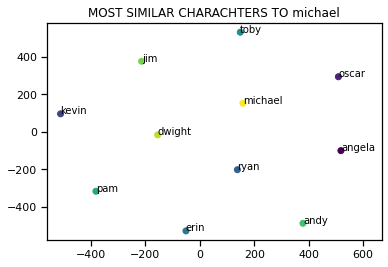

In [87]:
display_closestwords_tsnescatterplot(d2v_model,'michael',10)

<div class="alert alert-block alert-success">
    2.5 Doc2Vec 

It is possible to notice that trought the document embedding we obtain a realistic representation of the characters in the space. In particular the two closest character to him are 'jim' and 'dwight' which represent his main two assistants troughout the series. 

## 2.6 Language models 

In [236]:
class LM:
    def __init__(self,n,smoothing,input_corpus):
        random.seed(30)
        self.n = n
        self.counts = defaultdict(lambda: defaultdict(lambda: smoothing))
        self.letters = tuple([random.choice(string.ascii_letters) for i in range(n)])
        self.corpus = [line.strip().split() for line in input_corpus]

        self.keys = 0
        self.result = []
        
        for sentence in self.corpus:
            self.tokens = ['_***_' for i in range(n-1)] + sentence + ['_STOP_']
            for letters in nltk.ngrams(self.tokens, n):
                self.counts[tuple(letters[:-1])][letters[-1]] += 1
                
                
    def sample_next_word(self,cond=tuple()):
        
        keys, values = zip(*self.counts[cond].items())
        values = np.array(values)
        values /= values.sum() 
        sample = np.random.multinomial(1, values) # pick one position
        return keys[np.argmax(sample)]
    
    
    def fit(self,result):
        self.result = ['_***_' for i in range(self.n-1)] + result.split()
        
        for i in range((len(result.split())+1)):
            try:
                next_word = self.sample_next_word(tuple([self.result[n-i] for n in range((-(self.n-1)),0)]))
            except ValueError:
                pass
            
        self.result.append(next_word)
        
        c = self.n

        while next_word != '_STOP_':
            c -= 1
            if c-1 > 0:
                try:
                    next_word = self.sample_next_word(tuple([self.result[n] for n in range((-(self.n-1)),0)]))
                except ValueError:
                    next_word = self.sample_next_word(tuple(['_***_' for i in range(c-1)])+tuple([self.result[n] for n in range(-(self.n-c),0)]))
                self.result.append(next_word)
            else:     
                next_word = self.sample_next_word(tuple([self.result[n] for n in range((-(self.n-1)),0)]))
                self.result.append(next_word)
        
        return  str(' '.join(self.result[self.n-1:-1]))

In [237]:
impersonal_lm = LM(6,0.001,scripts.line_text.to_list())

In [244]:
impersonal_lm.fit('how are you doing?')

"how are you doing? We have that going out Tuesday... Okay? Sure, no, I can... I'll double-check that for you."

In [239]:
michael_lm_6 = LM(6,0.001,scripts[scripts['speaker']=='michael'].line_text.to_list())

In [240]:
michael_lm_6.fit('I like to be on top of you')

'I like to be on top of you Uh, wh-why would she say that?'

In [241]:
michael_lm_4 = LM(4,0.1,scripts[scripts['speaker']=='michael'].line_text.to_list())

In [245]:
michael_lm_4.fit("you're making this harder than it is")


"you're making this harder than it is Fine. I love you. I love ya Pam... okay. I'm leavin' inside Jim's car, I don't know how. Because you have great ideas. So Phyllis, I am giving everyone a little bit raw there. Um, but I am not going to say about it because I trusted Ryan's precious technology, and look where it got us."

In [253]:
dwight_lm_6 = LM(6,0.001,scripts[scripts['speaker']=='dwight'].line_text.to_list())


In [254]:
#DON'T TOUCH 
dwight_lm_6.fit("how is going at the farm")

'how is going at the farm Are you socialist?'

#### Extra - "That's what she said!"
'That's what she said' is one of the most famous catchphrase of the show. In this section I want to try if the MichaelScott language model is able to reproduce it in a 10.000 trial setting. 

In [255]:
c = 0 
for i in range(10000):
    a = michael_lm_6.fit("you're making this harder than it is")
    if "that's what she said" in a:
        print(a)
        print("THAT'S WHAT SHE SAID!")
        c+=1 
print(c)
        

you're making this harder than it is Okay, hold on. Hold on. Now I can't pay for your college. But you don't have to go to class to be in class. Online courses are a viable option to a traditional college experience. And the best way to start is to hit start. And up comes the toolbar, that's what she said. What we have to do here is go to Run, and then you look up to PowerPoint. And we are in. We are going to register. You hit register--- Updates are ready. I should update. Um, estimated time 12 minutes, so this should take 5 or 10 minutes.
THAT'S WHAT SHE SAID!
you're making this harder than it is A, that's what she said, and B, I wanted it to be impressive. The biggest day of the year deserves the biggest tree of the year.
THAT'S WHAT SHE SAID!
2


<div class="alert alert-block alert-success"> 
#### Extra - "That's what she said!"

As expected, n-grams language models are not much sensical but we can see that it is generally able to grasp develop meaningful sentence. Given the high variety of words that are used and the fact that the lines are very short, sometimes it seems to reproduce lines from the script, as the porbability of words repeating in a certain way, is skewed towards sentences whihc happened not so often in the script.

### 2.6.1 Language model on negative and positive reviews 
The usage of language models will also be applied to the reviews. As expected, these will make much more sense given that the corpus on which are trained is more detailed than the scripts are. Will be represented lm both for n-grams equal to 3 and 6 to see how much these are different. 

In [256]:
bad_reviews = reviews[reviews['sentiment']=='bad']
good_reviews = reviews[reviews['sentiment']=='good']

In [257]:
bad_reviews_lm_3 = LM(3,0.001,bad_reviews.Text.to_list())
good_reviews_lm_3 = LM(3,0.001,good_reviews.Text.to_list())
bad_reviews_lm_6 = LM(6,0.001,bad_reviews.Text.to_list())
good_reviews_lm_6 = LM(6,0.001,good_reviews.Text.to_list())

In [260]:
bad_reviews_lm_3.fit('how was the episode?')

'how was the episode? Wtf is this a prelude into season 9? I hope it get better.'

In [261]:
good_reviews_lm_3.fit('how was the episode?')

'how was the episode? This was the best storyline, and it seems to have light hearted yet meaningful way.'

In [271]:
bad_reviews_lm_6.fit('how was the episode?')

"how was the episode? Started watching the office us a month ago for the 1st time and was so sad that I am going to its end as it was so damn funny, romantic and crazy at the same time. Always amazed that how I missed this TV show for 10 years and hooked up from you tube clips.I'm glad they came this low. I cannot in good heart continue from here. I skipped to the season 8 finale just to see what happens to Nellie who single handedly ruined the whole series. It is just stupid unrealistic.Respect I had for the whole show was ruined from this."

In [281]:
good_reviews_lm_6.fit('how was the episode?')

'how was the episode? To me, it is one of the greatest episode of the series.It captures broken dreams and feeling of a "dead-end job" so good. Represented by Jan, Corporate starts this episode portrayed as a thoughful, supportive big sister and shows its true colors when it first hears the talks of a union.It ends with the beautiful performance of Jenna Fischer. It is simply great.'

<div class="alert alert-block alert-success"> 
2.6.1 Language model on negative and positive reviews 

The language models, even if not much sensical, are able to capture the sentiment of the kind of reviews on which they are trained on. 

---

### 2.6.2 Conversational Language model 
In this analysis i have decided to implement the LM in a peculiar way to simulate a real conversation between two of the main_ch of the series. Writing a new 'script' is possible by just selecting the character's name and how long you mean to continue the conversation. It is strongly suggested to use just characters that are in the main_ch list.   

In [283]:
def sentence_reducer(sent):
    pos = 0 
    sent.replace("...",".")
    for i in range(len(list(sent[:-1]))-1):
        if sent[i] in ['!','.','?']:
            pos = i 
    return sent[pos+2:]

def conversational_lm_any_ch(starter, ch1, ch2, iteractions = 2, ngrams = 6, smoothing = 0.001):
    '''For the function to work is necessary to end the starter with one of the folloing special characters: !,.,?
    the starter has to be intended as what the character 2 will say to start the conversation'''
    if starter[-1] not in ['!','.','?']:
        raise Exception("you need to end the sentence with one of the folloing special characters: '!','.','?' ")
        
    lm1 = LM(ngrams,smoothing,scripts[scripts['speaker']==ch1].line_text.to_list())
    lm2 = LM(ngrams,smoothing,scripts[scripts['speaker']==ch1].line_text.to_list())
    
    print(ch2 +': ' + starter)
    sent1 = lm1.fit(starter)
    print(ch1 +': ' + sent1[len(starter):])
    time.sleep(5)
    sent2 = lm2.fit(sentence_reducer(sent1))
    print(ch2 +': ' + sent2[len(sentence_reducer(sent1)):])
    time.sleep(5)
    i = 1 
    while i < iteractions:
        sent1 = lm1.fit(sentence_reducer(sent2))
        print(ch1 + ': ' + sent1[len(sentence_reducer(sent2)):])
        time.sleep(5)
        sent2 = lm2.fit(sentence_reducer(sent1))
        print(ch2 + ': ' + sent2[len(sentence_reducer(sent1)):])
        time.sleep(5)
        i+=1

In [284]:
conversational_lm_any_ch("You're the best.", 'michael','dwight')

dwight: You're the best.
michael:  Could we please pull over and pull down the top, I do not feel good.
dwight:  Ok, Oscar, I don't need the whole enchilada just the bullet points.
michael:  What is she so upset about?
dwight:  Jim, Jim....


In [285]:
conversational_lm_any_ch("Hi, pam.", 'pam','jim', iteractions = 5, ngrams = 7)

jim: Hi, pam.
pam:  Doesn't feel right.
jim:  Um, I think I'm gonna be up at the lake.
pam:  Yes, you clean all the mugs in the sink.
jim:  Sure, if you weigh 105 pounds.
pam:  No, I know you are.
jim:  You could have just told us what you were thinking.
pam:  So, does anyone wanna know where I've been for the last 2 hours?
jim:  So Michael said we can do whatever we want cake-wise. What do we want?
pam:  Oh yeah, sure. Um, I hope I can help.
jim:  Wow, that is wonderful, congratulations.


<div class="alert alert-block alert-success"> 
2.6.2 Conversational Language model 

We can notice that sometime, the sentences of each character are referred to other character of the series,in fact the conversation hardly make sense as a whole. Being language models based on stochasticity and n-grams we could not expect more. Would be interesting to implement it in such a way in which, depending on the specific character who is called in the conversation her/him intervenes. 

---

### 2.7 Clustering on reviews

Given the analysis conducted in 2.3 I have decided to perform clustering trying to detect some patterns in the words used in the reviews.    

In [102]:
XSVD = TruncatedSVD(n_components=300).fit_transform(X_rew)
k = 9
agg = AgglomerativeClustering(n_clusters=k)
sample = np.random.choice(len(XSVD), replace=False, size=600)
agg_sample_ids = agg.fit_predict(XSVD[sample])
centroids = np.array([XSVD[sample][agg_sample_ids == c].mean(axis=0) for c in range(k)])
km = KMeans(n_clusters=k, n_jobs=-1, init=centroids)
km.fit(XSVD)
plot_sample = np.random.choice(XSVD.shape[0], replace=False, size=300)

/Users/valedipalo/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/Users/valedipalo/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:984: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


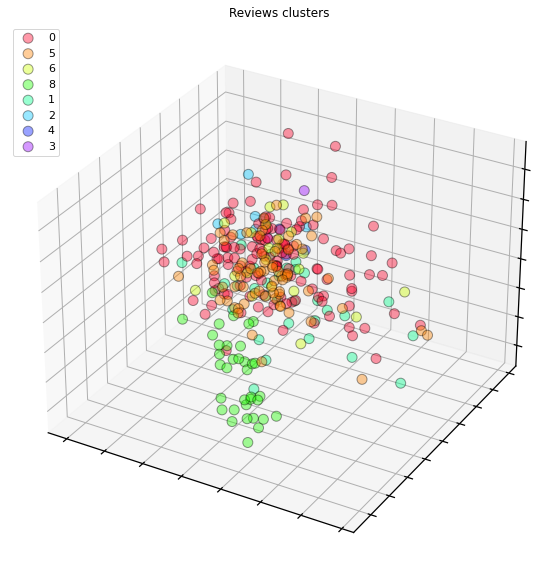

In [115]:
plot_vectors(XSVD[plot_sample], labels=km.labels_[plot_sample], dimensions=3, palette = 'gist_rainbow',title = 'Reviews clusters')

<div class="alert alert-block alert-success"> 
    2.7 Clustering on reviews

I used lemmatized comments to agglomerative cluster the reviews. I performed clustering on the entire review group jointly. 

## 3. Visualization (10 pts)

Provide visualizations (plots, not tables) for **all** of your analyses above (except maybe language models). The visualizations should be informative (not just a copy-paste of the class code). Be creative. 

Just please do not use word clouds...

#### 3.1 Data exploration for analysis preparation [2.1] 
In this section has been used graphs of different kinds, in particular: 
- barplots to indicate the percentual presence of each character in episodes and in scenes
- time series graph: to evaluate the presence of each of the main character during the show
- grouped bar charts: to evaluate the sentiment of the reviews, season by season. 

#### 3.2 Syntatic analysis: NER & POS [2.2.1 and 2.2.2]
In these two section have been used:
- barplots to indicate the frequencies of NE and POS in the two analyzed dataframes 

#### 3.3. TfIdf analysis: Figure out important words and clusters in the text [2.3] 
In this section have been used:
- barplots to represent word frequencies (for the scripts filtered on the main characters the 'pam' script and the reviews) 
- scatterplots to evaluate TfIdf (for the scripts filtered on the main characters and the reviews) 
- bi-dimensional and tri-dimensional reduction applied to tfidf to evaluate clusters (for the scripts filtered on the main characters and the reviews) 

#### 3.4 Word2vec: Similiarities visualization [2.4]
In this section, dimensionality reduction trough t-SNE has been used to capture similiarities among different words. 
- t-SNE bidimensional representation of distances in word2vec

#### 3.5 Doc2Vec: Similiarities visualization [2.5]
In this section, dimensionality reduction trough t-SNE has been used to capture similiarities among different words. 
- t-SNE bidimensional representation of distances in doc2vec

#### 3.6 Clustering on reviews [2.7]
In this section has been used:
- bi-dimensional and tri-dimensional reduction applied to tfidf to evaluate agglomerative clustering.